In [1]:
# Modules - general
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy

#Modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

import xgboost as xgb
from xgboost import plot_importance, plot_tree


#Settings
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)
plt.style.use('ggplot')
sns.set(style="whitegrid")
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Preparing the data for modelling

### Data imports

Import transformed_listings.csv resulted from notebook 1.Vienna_Listings_17_03_2020_PreModelling

In [2]:
transformed_listings = pd.read_csv('D:/disertation/project/vienna_data/transformed_listings.csv')
listings = pd.read_csv('D:/disertation/project/vienna_data/listings.csv')

In [3]:
#setting the ID column as the index
transformed_listings.set_index('id', inplace=True) 

In [4]:
transformed_listings.head()

,host_is_superhost,host_listings_count,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,instant_bookable,host_days_active,air_conditioning,balcony,bed_linen,tv,coffee_machine,cooking_basics,white_goods,elevator,child_friendly,parking,host_greeting,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,smoking_allowed,host_response_time_a few days or more,host_response_time_unknown,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_rate_0-49%,host_response_rate_100%,host_response_rate_50-89%,host_response_rate_90-99%,host_response_rate_unknown,host_acceptance_rate_0-49%,host_acceptance_rate_100%,host_acceptance_rate_50-89%,host_acceptance_rate_90-99%,host_acceptance_rate_unknown,district_Alsergrund,district_Brigittenau,district_Donaustadt,district_Dbling,district_Favoriten,district_Floridsdorf,district_Hernals,district_Hietzing,district_Innere Stadt,district_Josefstadt,district_Landstra§e,district_Leopoldstadt,district_Liesing,district_Margareten,district_Mariahilf,district_Meidling,district_Neubau,district_Ottakring,district_Penzing,district_Rudolfsheim-Fnfhaus,district_Simmering,district_Wieden,district_Whring,property_type_Apartment,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,review_scores_rating_0-79/100,review_scores_rating_80-94/100,review_scores_rating_95-100/100,review_scores_rating_no_reviews,review_scores_accuracy_0-8/10,review_scores_accuracy_10/10,review_scores_accuracy_9/10,review_scores_accuracy_no_reviews,review_scores_cleanliness_0-8/10,review_scores_cleanliness_10/10,review_scores_cleanliness_9/10,review_scores_cleanliness_no_reviews,review_scores_checkin_0-8/10,review_scores_checkin_10/10,review_scores_checkin_9/10,review_scores_checkin_no_reviews,review_scores_communication_0-8/10,review_scores_communication_10/10,review_scores_communication_9/10,review_scores_communication_no_reviews,review_scores_location_0-8/10,review_scores_location_10/10,review_scores_location_9/10,review_scores_location_no_reviews,review_scores_value_0-8/10,review_scores_value_10/10,review_scores_value_9/10,review_scores_value_no_reviews,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,time_since_first_review_0-6_months,time_since_first_review_1-2_years,time_since_first_review_2-3_years,time_since_first_review_4+_years,time_since_first_review_6-12_months,time_since_first_review_no_reviews,time_since_last_review_0-2_weeks,time_since_last_review_1+_year,time_since_last_review_2-6_months,time_since_last_review_2-8_weeks,time_since_last_review_6-12_months,time_since_last_review_no_reviews
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15883,0.00000,6.00000,1.00000,3,1.00000,1.00000,2.00000,85,0,0,2,10,1,365,314,11,1,3749.00000,1.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
38768,0.00000,3.00000,0.00000,5,1.00000,1.00000,3.00000,65,150,35,2,12,3,100,201,313,0,3534.00000,0.00000,1.00000,1.00000,0.00000,1.00000,1.00000,1.00000,0.00000,1.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
40625,1.00000,16.00000,1.00000,6,1.00000,2.00000,4.00000,130,0,55,5,15,1,180,324,153,1,3528.00000,1.00000,0.00000,1.00000,1.00000,1.00000,1.0000

In [5]:
transformed_listings.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11996 entries, 15883 to 42926580
Data columns (total 124 columns):
 #   Column                                           Dtype  
---  ------                                           -----  
 0   host_is_superhost                                float64
 1   host_listings_count                              float64
 2   host_identity_verified                           float64
 3   accommodates                                     int64  
 4   bathrooms                                        float64
 5   bedrooms                                         float64
 6   beds                                             float64
 7   price                                            int64  
 8   security_deposit                                 int64  
 9   cleaning_fee                                     int64  
 10  guests_included                                  int64  
 11  extra_people                                     int64  
 12  minimum_ni

In [6]:
transformed_listings.columns

Index(['host_is_superhost', 'host_listings_count', 'host_identity_verified',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'security_deposit', 'cleaning_fee',
       ...
       'time_since_first_review_2-3_years', 'time_since_first_review_4+_years',
       'time_since_first_review_6-12_months',
       'time_since_first_review_no_reviews',
       'time_since_last_review_0-2_weeks', 'time_since_last_review_1+_year',
       'time_since_last_review_2-6_months', 'time_since_last_review_2-8_weeks',
       'time_since_last_review_6-12_months',
       'time_since_last_review_no_reviews'],
      dtype='object', length=124)

### Multicolinearity

Before the effective modelling of the data, the correlations between the variables will be analyzed.  

Although the XGBRegressor is robust in terms of the existence of collinear variables, the aim was to eliminate most strongly correlated variables in order to reduce the complexity of the analysis and improve the performance of linear regression.

In [19]:
def multi_collinearity_heatmap(df, figsize=(15,15)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

D:\installs\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 154 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\installs\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 159 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\installs\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 154 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\installs\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 159 missing from current font.
  font.set_text(s, 0, flags=flags)


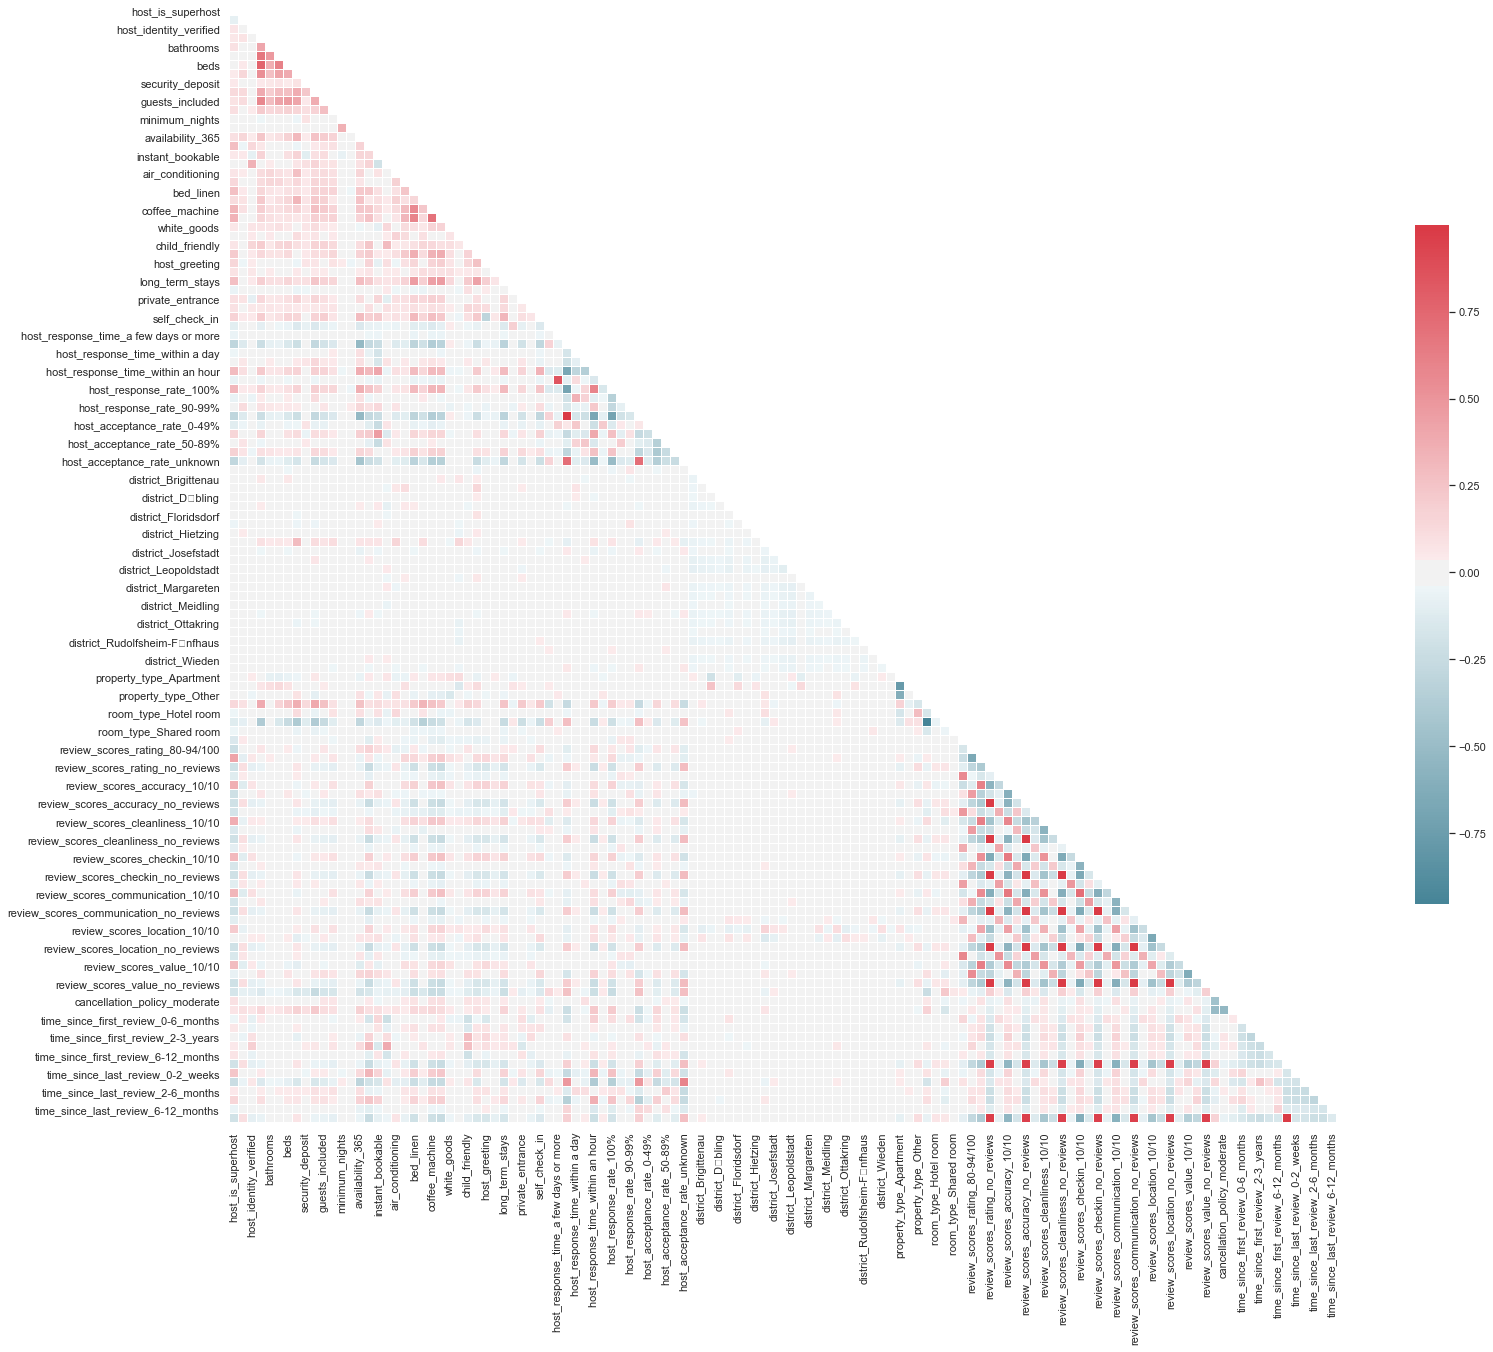

In [8]:
multi_collinearity_heatmap(transformed_listings, figsize=(25,25))
plt.savefig("Heatmap - transformed_listings.png", format="png",dpi = 300)

It doesn't look like there are any significant collinear relationships with districts, so these will temporarily be dropped to produce a clearer heatmap for the remaining features:

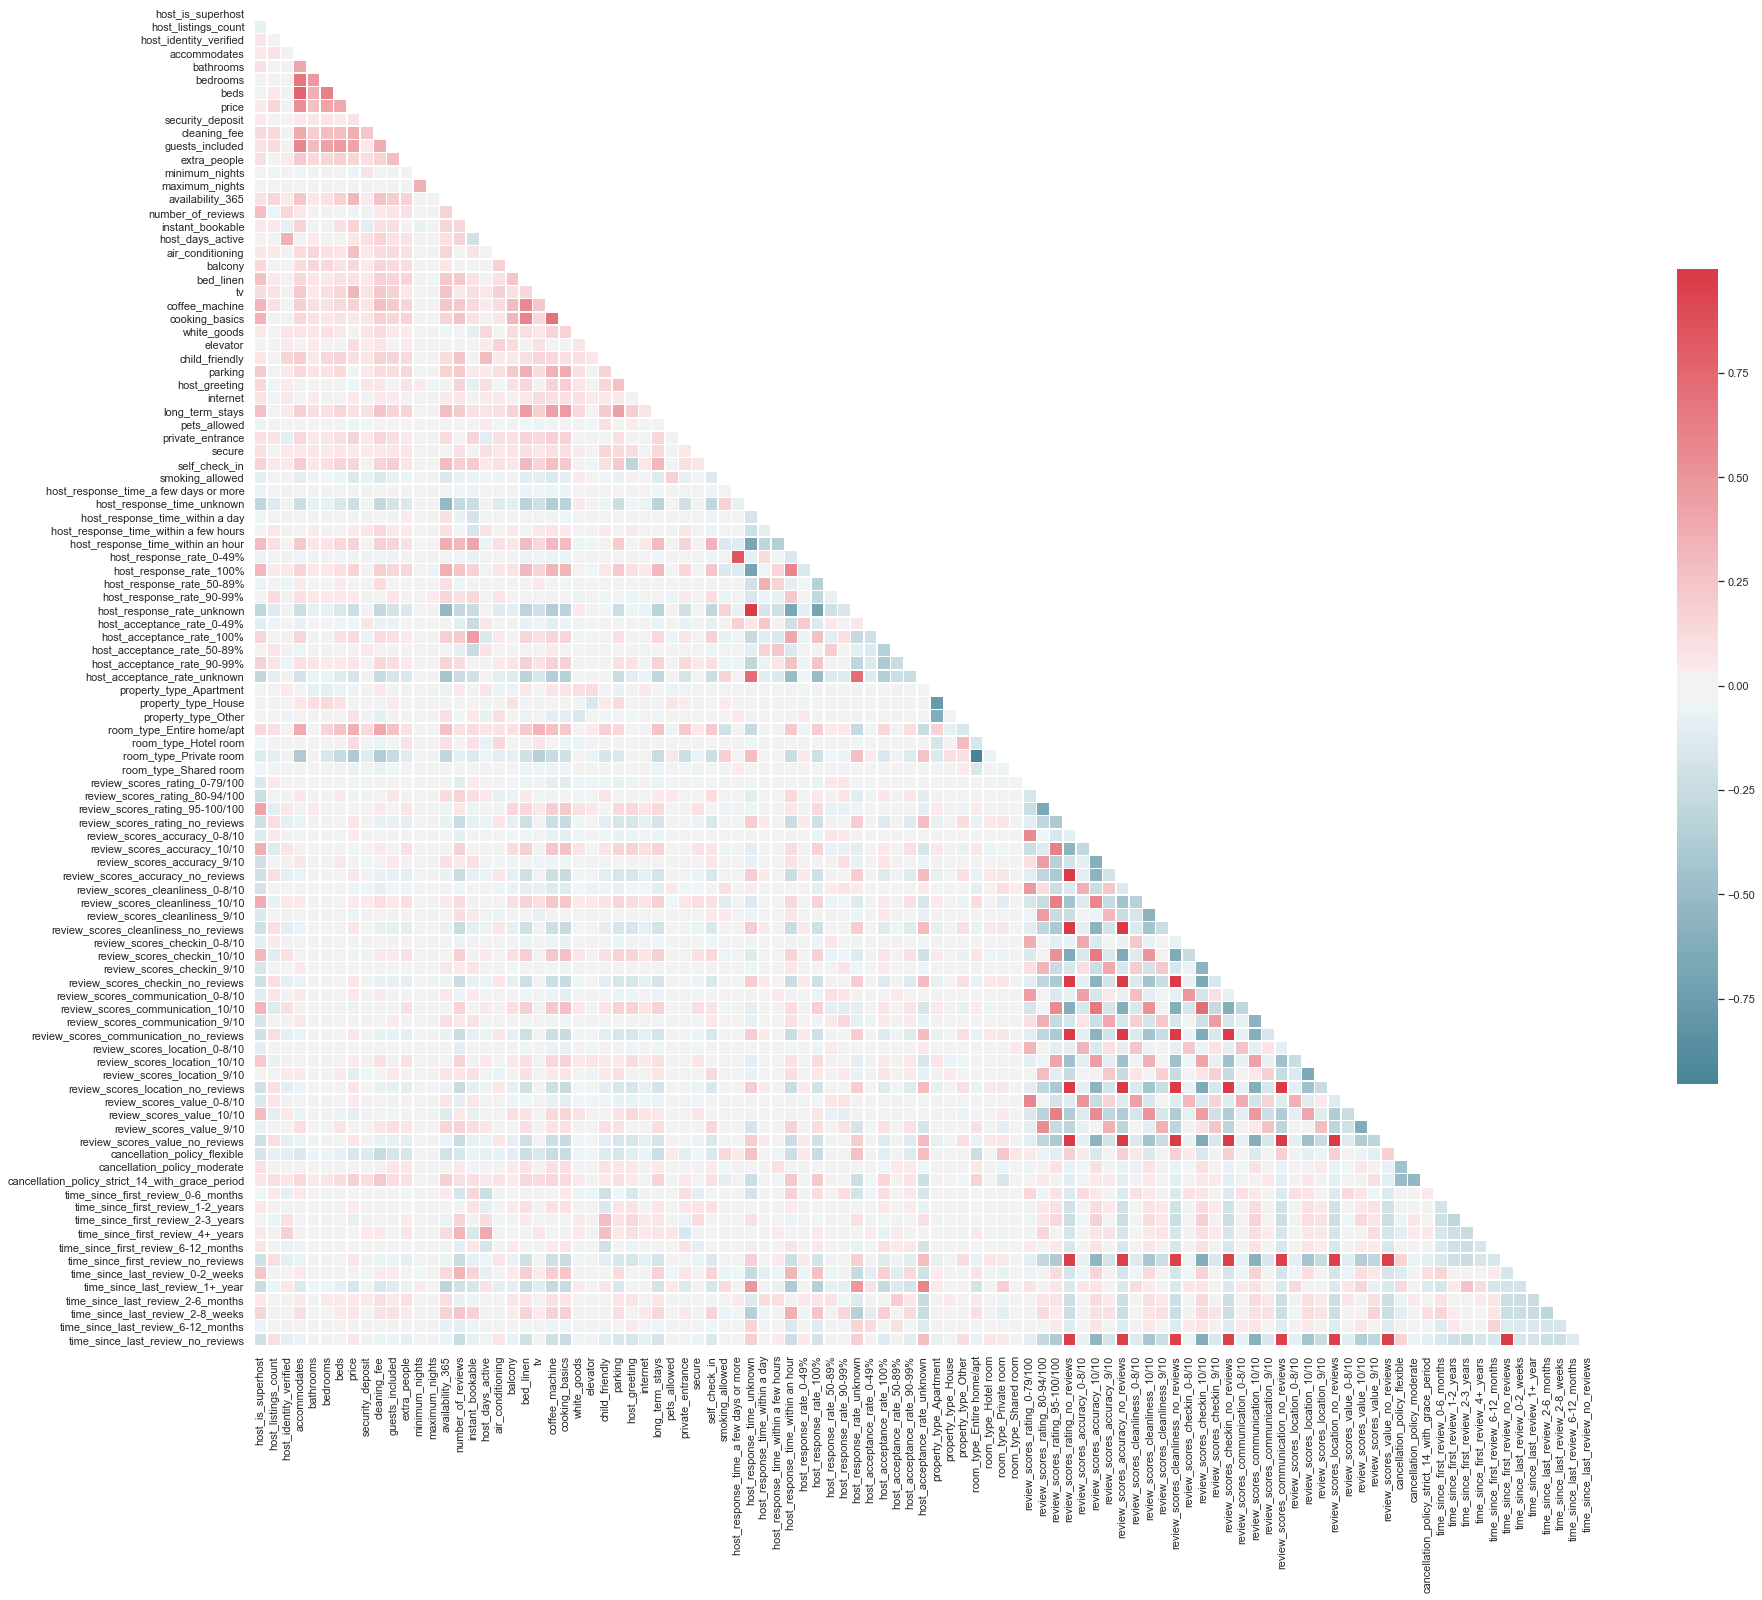

In [9]:
multi_collinearity_heatmap(transformed_listings.drop(list(transformed_listings.columns[transformed_listings.columns.str.startswith('district')]), axis=1), figsize=(30,30))
plt.savefig("Heatmap - transformed_listings without districts.png", format="png",dpi = 300)

High correlation between:
  
+ host_response_rate_0-49% - host_response_time_a few days or more 
+ host_response_rate_100% - host_response_time_unknown, host_response_time_within an hour
+ host_response_rate_unknown - host_response_time_unknown, host_response_time_within an hour, host_response_rate_100%

  
The features related to host_response_rate will be dropped. + host response time unknown 

+ property_type_House, property_type_Other - property_type_Apartment  
  
The property_type_Apartment apartment will be dropped.  

+ room_type_Private room - room_type_Entire home/apt  
  
The room_type_Private room will be dropped
  
+  bedrooms, beds, guests_included, bathrooms - accommodates
  
Beds, guests_included and bedrooms will be dropped
  

+ review_scores_accuracy_no_reviews - review_scores_rating_no_reviews
+ reviews_scores_cleanliness_no_reviews - review_scores_rating_no_reviews, review_scores_accuracy_no_reviews
+ reviews_scores_checkin_no_reviews - review_scores_rating_no_reviews, review_scores_accuracy_no_reviews...
+ reviews_scores_communication_no_reviews - review_scores_rating_no_reviews, review_scores_accuracy_no_reviews...
+ reviews_scores_location_no_reviews - review_scores_rating_no_reviews, review_scores_accuracy_no_reviews...
+ reviews_scores_value_no_reviews - review_scores_rating_no_reviews, review_scores_accuracy_no_reviews...
+ time_since_first_review_no_reviews - review_scores_rating_no_reviews, review_scores_accuracy_no_reviews...
+ time_since_last_review_no_reviews - review_scores_rating_no_reviews, review_scores_accuracy_no_reviews.., time_since_first_review_no_reviews
  
The no reviews columns will be dropped


### Feature filtering

In [7]:
corrMatrix = transformed_listings.corr()

In [8]:
corrMatrix[abs(corrMatrix['price'])<0.01]['price']

host_identity_verified                   0.00967
maximum_nights                           0.00483
white_goods                              0.00481
host_response_time_a few days or more    0.00292
host_response_time_within a day          0.00062
host_response_rate_0-49%                -0.00970
district_Alsergrund                      0.00208
district_Brigittenau                     0.00187
district_Donaustadt                     -0.00940
district_Dbling                        -0.00898
district_Hietzing                       -0.00720
district_Mariahilf                       0.00411
district_Neubau                          0.00054
district_Simmering                      -0.00252
property_type_House                      0.00345
review_scores_rating_95-100/100         -0.00585
review_scores_checkin_9/10              -0.00511
review_scores_communication_9/10        -0.00191
review_scores_location_0-8/10           -0.00642
time_since_first_review_6-12_months     -0.00029
time_since_last_revi

In [9]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations\n")
print(get_top_abs_correlations(corrMatrix, 50))

Top Absolute Correlations

host_response_time_unknown              host_response_rate_unknown               1.00000
time_since_first_review_no_reviews      time_since_last_review_no_reviews        1.00000
review_scores_cleanliness_no_reviews    review_scores_checkin_no_reviews         1.00000
review_scores_accuracy_no_reviews       review_scores_cleanliness_no_reviews     1.00000
review_scores_location_no_reviews       review_scores_value_no_reviews           1.00000
review_scores_accuracy_no_reviews       review_scores_checkin_no_reviews         1.00000
review_scores_checkin_no_reviews        review_scores_location_no_reviews        1.00000
review_scores_accuracy_no_reviews       review_scores_communication_no_reviews   1.00000
review_scores_cleanliness_no_reviews    review_scores_location_no_reviews        1.00000
review_scores_accuracy_no_reviews       review_scores_location_no_reviews        1.00000
review_scores_cleanliness_no_reviews    review_scores_communication_no_reviews   1.

In [10]:
transformed_listings.drop(list(transformed_listings.columns[transformed_listings.columns.str.endswith('no_reviews')]), axis=1, inplace=True)

In [11]:
top_corr = get_top_abs_correlations(transformed_listings.corr(), 20000)

In [12]:
top_corr[abs(top_corr)>0.75]

host_response_time_unknown             host_response_rate_unknown           1.00000
room_type_Entire home/apt              room_type_Private room               0.98514
host_response_time_a few days or more  host_response_rate_0-49%             0.97763
accommodates                           beds                                 0.96371
coffee_machine                         cooking_basics                       0.95983
host_response_time_unknown             host_acceptance_rate_unknown         0.94841
host_response_rate_unknown             host_acceptance_rate_unknown         0.94841
review_scores_checkin_10/10            review_scores_communication_10/10    0.94405
bed_linen                              cooking_basics                       0.93842
                                       coffee_machine                       0.93212
review_scores_accuracy_10/10           review_scores_communication_10/10    0.92602
                                       review_scores_checkin_10/10          

In [13]:
print(top_corr[top_corr.index.isin(['price'], level=0)])

price  guests_included                                   0.81632
       cleaning_fee                                      0.77867
       room_type_Private room                            0.73240
       tv                                                0.70868
       room_type_Entire home/apt                         0.70825
       availability_365                                  0.64756
       air_conditioning                                  0.59723
       district_Innere Stadt                             0.53186
       host_response_rate_unknown                        0.52404
       host_response_time_unknown                        0.52404
       private_entrance                                  0.50381
       time_since_last_review_1+_year                    0.50264
       extra_people                                      0.49056
       self_check_in                                     0.48775
       host_acceptance_rate_unknown                      0.48616
       cancellation_polic

In [14]:
# Dropping collinear features
to_drop = ['beds',
           'bedrooms',
           'guests_included', 
           'host_response_rate_unknown',
           'host_response_rate_0-49%',
           'host_acceptance_rate_unknown',
           'property_type_Apartment',
           'room_type_Private room']

transformed_listings.drop(to_drop, axis=1, inplace=True)

There can be seen a lack of correlation between price and columns starting with "time_since" - these features will also be dropped from the model.

In [16]:
to_drop2 = list(transformed_listings.columns[transformed_listings.columns.str.startswith('time_since')])
transformed_listings.drop(to_drop2, axis=1, inplace=True)

In [17]:
transformed_listings.head()

,host_is_superhost,host_listings_count,host_identity_verified,accommodates,bathrooms,price,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,instant_bookable,host_days_active,air_conditioning,balcony,bed_linen,tv,coffee_machine,cooking_basics,white_goods,elevator,child_friendly,parking,host_greeting,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,smoking_allowed,host_response_time_a few days or more,host_response_time_unknown,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_rate_100%,host_response_rate_50-89%,host_response_rate_90-99%,host_acceptance_rate_0-49%,host_acceptance_rate_100%,host_acceptance_rate_50-89%,host_acceptance_rate_90-99%,district_Alsergrund,district_Brigittenau,district_Donaustadt,district_Dbling,district_Favoriten,district_Floridsdorf,district_Hernals,district_Hietzing,district_Innere Stadt,district_Josefstadt,district_Landstra§e,district_Leopoldstadt,district_Liesing,district_Margareten,district_Mariahilf,district_Meidling,district_Neubau,district_Ottakring,district_Penzing,district_Rudolfsheim-Fnfhaus,district_Simmering,district_Wieden,district_Whring,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Hotel room,room_type_Shared room,review_scores_rating_0-79/100,review_scores_rating_80-94/100,review_scores_rating_95-100/100,review_scores_accuracy_0-8/10,review_scores_accuracy_10/10,review_scores_accuracy_9/10,review_scores_cleanliness_0-8/10,review_scores_cleanliness_10/10,review_scores_cleanliness_9/10,review_scores_checkin_0-8/10,review_scores_checkin_10/10,review_scores_checkin_9/10,review_scores_communication_0-8/10,review_scores_communication_10/10,review_scores_communication_9/10,review_scores_location_0-8/10,review_scores_location_10/10,review_scores_location_9/10,review_scores_value_0-8/10,review_scores_value_10/10,review_scores_value_9/10,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15883,0.00000,6.00000,1.00000,3,1.00000,85,0,0,10,1,365,314,11,1,3749.00000,1.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0
38768,0.00000,3.00000,0.00000,5,1.00000,65,150,35,12,3,100,201,313,0,3534.00000,0.00000,1.00000,1.00000,0.00000,1.00000,1.00000,1.00000,0.00000,1.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1
40625,1.00000,16.00000,1.00000,6,1.00000,130,0,55,15,1,180,324,153,1,3528.00000,1.00000,0.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0
51287,0.00000,3.00000,0.00000,3,1.00000,60,150,30,8,3,100,137,294,0,3534.00000,0.00000,1.00000,1.00000,0.00000,1.00000,1.00000,1.00000,0.00000,1.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1
70568,1.00000,7.00000,1.00000,2,1.00000,59,150,40,15,3,365,365,10,0,3342.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,1.00000,1.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1


**Final assessment of multi-collinearity**

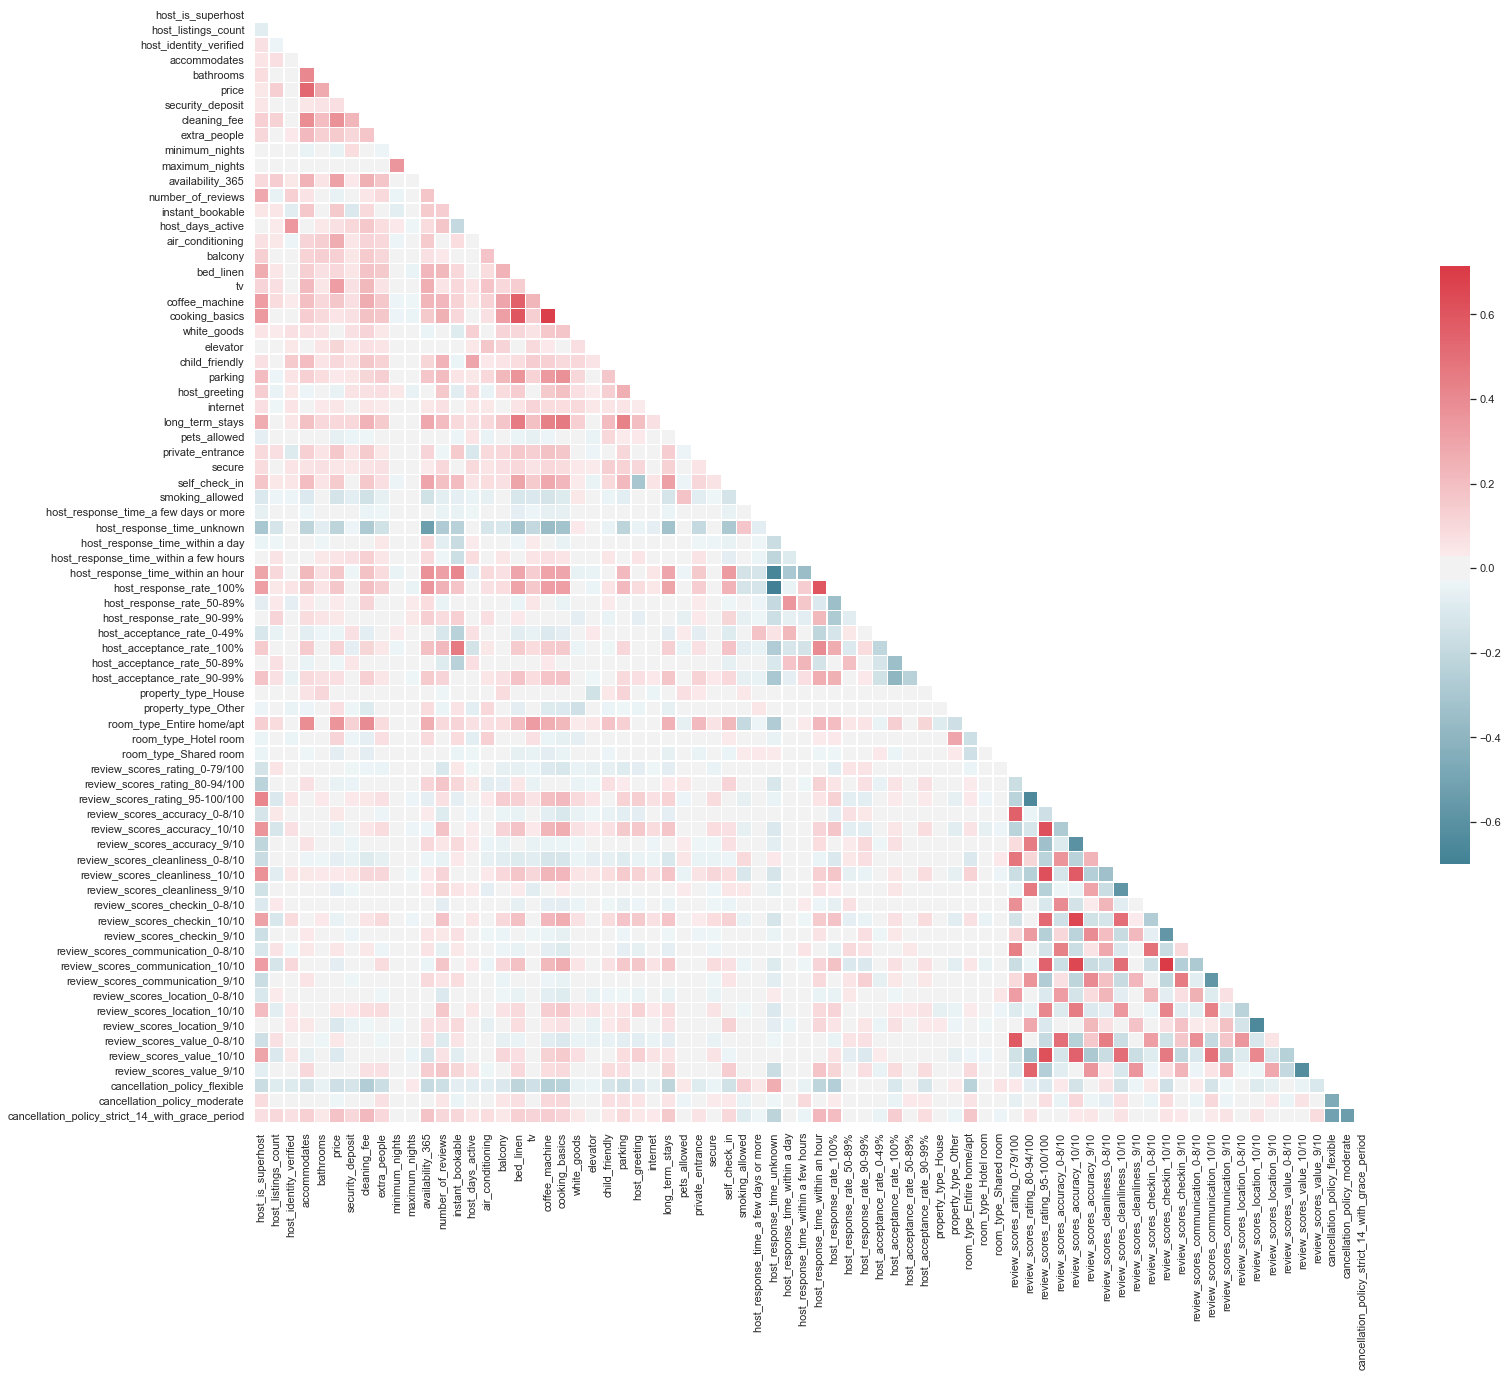

In [20]:
multi_collinearity_heatmap(transformed_listings.drop(list(transformed_listings.columns[transformed_listings.columns.str.startswith('district')]), axis=1), figsize=(25,22))


There are still some fairly strong correlations between highly rated properties of different reviews categories - i.e. if a property gets a 10/10 for one category, it is likely to get a 10/10 for other categories. However, these will be left in for now and can be experimented with later to see if removing them improves the model.



In [22]:
top_corr2 = get_top_abs_correlations(transformed_listings.corr(), 20000)

print(top_corr2[abs(top_corr2)>0.75])

coffee_machine                      cooking_basics                       0.95424
review_scores_checkin_10/10         review_scores_communication_10/10    0.94297
bed_linen                           cooking_basics                       0.92785
review_scores_accuracy_10/10        review_scores_communication_10/10    0.92404
bed_linen                           coffee_machine                       0.91981
review_scores_rating_95-100/100     review_scores_value_10/10            0.91775
review_scores_rating_0-79/100       review_scores_value_0-8/10           0.91646
review_scores_accuracy_10/10        review_scores_checkin_10/10          0.91582
review_scores_rating_95-100/100     review_scores_cleanliness_10/10      0.91099
review_scores_rating_0-79/100       review_scores_accuracy_0-8/10        0.90751
review_scores_rating_95-100/100     review_scores_accuracy_10/10         0.89860
review_scores_accuracy_10/10        review_scores_cleanliness_10/10      0.88552
review_scores_accuracy_0-8/1

In [23]:
transformed_listings.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11996 entries, 15883 to 42926580
Data columns (total 97 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   host_is_superhost                                11996 non-null  float64
 1   host_listings_count                              11996 non-null  float64
 2   host_identity_verified                           11996 non-null  float64
 3   accommodates                                     11996 non-null  int64  
 4   bathrooms                                        11996 non-null  float64
 5   price                                            11996 non-null  int64  
 6   security_deposit                                 11996 non-null  int64  
 7   cleaning_fee                                     11996 non-null  int64  
 8   extra_people                                     11996 non-null  int64  
 9   minimum_nights       

In [24]:
transformed_listings.shape

(11996, 97)

## Standardising and normalising

Other than availability_365 and host_days_active, the remaining numerical features are all postively skewed and could benefit from log transformation.

In [21]:
numerical_columns = ['accommodates', 'availability_365', 'bathrooms', 'cleaning_fee', 'extra_people', 'host_days_active', 'host_listings_count', 'maximum_nights', 'minimum_nights', 'number_of_reviews', 'price', 'security_deposit']

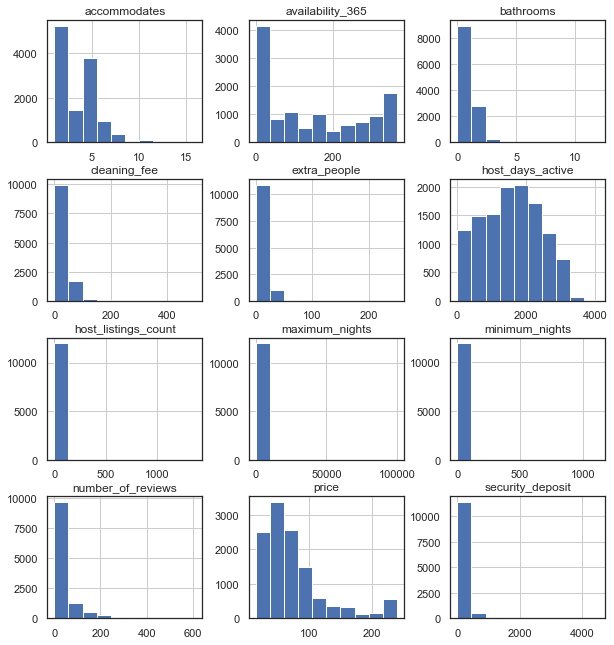

In [22]:
transformed_listings[numerical_columns].hist(figsize=(10,11));

In [23]:
# Log transforming columns 
numerical_columns = [i for i in numerical_columns if i not in ['availability_365', 'host_days_active']] 

for col in numerical_columns:
    transformed_listings[col] = transformed_listings[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_listings[col] = np.log(transformed_listings[col])

This appears to have helped some of the distributions, although some (e.g. cleaning fee, extra people fee and security deposit) contain a large number of 0s, which means these features are not normally distributed. Most importantly, however, the target variable price now appears much more normally distributed.

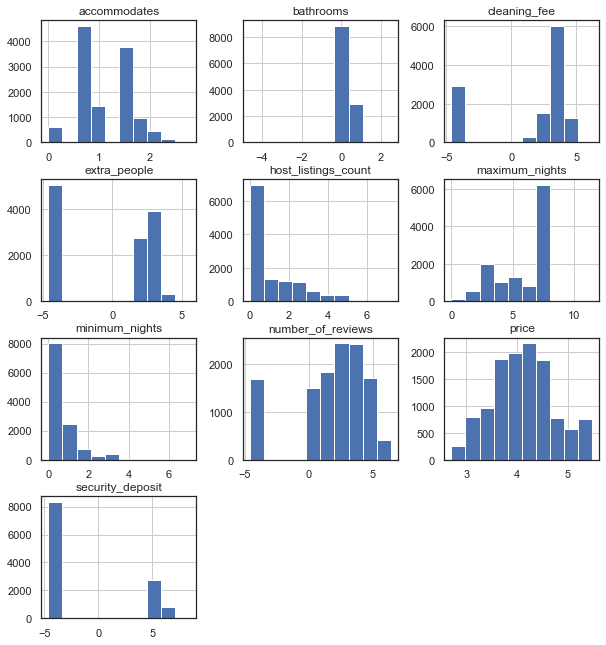

In [24]:
transformed_listings[numerical_columns].hist(figsize=(10,11));

Finally, the predictive features X and the target feature y can be separated, and X will be standardised.StandardScaler from sklearn will be used, but the type of scaling used could be experimented with.

scaler.fit_transform() will be used to transform the y variable for the model.

In [25]:
# Separating X and y
y = transformed_listings.price
X = transformed_listings.drop('price', axis=1)

# StandardScaler - Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

# Modelling

Now that the data preprocessing is over, we can start applying different models. We will compare two models:
* An OLS Regression, using LinearRegression from Scikit-Learn
* Gradient Boosted Regression Trees, with the XGBRegressor from XGBoost  


The evaluation metrics used will be MSE and MAE (mean squared error and mean absolut error - for loss) and r-squared (coefficient of determination - for accuracy).

 #### $ MSE = \frac{1}{n} \sum_{i=1}^{n} \big(y^{(i)} - \hat{y}^{(i)}  \big) ^2$
 #### $ MAE = \frac{1}{n} \sum_{i=1}^{n} \big|y^{(i)} - \hat{y}^{(i)}  \big| $


In [26]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# M1 - Linear Regression (Hedonic Price Model) and Ridge Regularization

The hedonic model involves regressing observed asking-prices for the listing against those attributes of a property hypothesized to be determinants of the asking-price. It comes from hedonic price theory which assumes that a commodity, such as a house can be viewed as an aggregation of individual components or attributes (Griliches, 1971). Consumers are assumed to purchase goods embodying bundles of attributes that maximize their underlying utility functions (Rosen, 1974).

In essence, this model is a mere Linear Regression model. A noteworthy hypothesis for this model is that the predictive variables must not be correlated. Applying these types of models to data sets with strongly correlated variables leads to low performance in predictions and impediments in the correct interpretation of results. 

In this case, the data set on which this model will be applied, this assumption is difficult to respect, due to the nature of the data. 

Moreover, the OLS method finds an optimal set of parameters for which the sum of the squares of the residuals is minimized. However, this method does not consider the determination of some variables that are more important than others in making the forecast, but only of the coefficients that minimize the error. Thus, the model becomes more and more complex when many explanatory variables are added.  

To try to improve the model results, Ridge regression will also be applied, seen as a way to reduce the complexity of the model resulting from the application of a multivariate linear regression.

The results will be used as a comparison baseline for the XGBRegressor model, even though the lineara regression isn't a correlation-robust model.


In [27]:
hpm_start = time.time()

# LinearRegression instance and training
hpm = LinearRegression()
hpm.fit(X_train, y_train)

# Predictions on test dataset
training_preds_hpm = hpm.predict(X_train)
val_preds_hpm = hpm.predict(X_test)

hpm_end = time.time()


print(f"Time: {round((hpm_end - hpm_start),4)} seconds\n")
print("Multivariate Linear Regression")
# Check the predictions against the actual values by using the metrics:
print("\nTraining MAE:", round(mean_absolute_error(y_train, training_preds_hpm),4))
print("Validation MAE:", round(mean_absolute_error(y_test, val_preds_hpm),4))

print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_hpm),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_hpm),4))

print("\nTraining R2:", round(r2_score(y_train, training_preds_hpm),4))
print("Validation R2:", round(r2_score(y_test, val_preds_hpm),4))


Time: 0.0947 seconds

Multivariate Linear Regression

Training MAE: 0.2948
Validation MAE: 0.3009

Training MSE: 0.1475
Validation MSE: 0.1548

Training R2: 0.6125
Validation R2: 0.6003


Given the log-transformed data (including the price), the actual MAE would be interpreted as % using:

In [28]:
print(f"MAE: {round(np.expm1(0.3285)*100, 2)}%")

MAE: 38.89%


This means that our features explain approximately 57% of the variance in our target variable.

Interpreting the mean_squared_error value is somewhat more intuitive that the r-squared value. The MSE measures the distance between our predicted values and actual values.

We can compare the actual output values for X_test with the predicted values in plot:

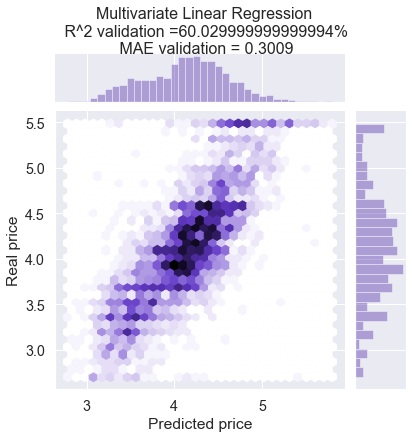

In [29]:
sns.set(font_scale=1.3)
ax = sns.jointplot(x = val_preds_hpm, y = y_test, color = '#512da8', 
                   kind = 'hex').set_axis_labels('Predicted price','Real price')

ax.fig.suptitle(f'Multivariate Linear Regression \n R^2 validation ={100*round(r2_score(y_test, val_preds_hpm),4)}% \n MAE validation = {round( mean_absolute_error(y_test, val_preds_hpm),4)} ', fontsize = 16)
plt.subplots_adjust(top=0.87)
plt.show()

## Cofficients 

In [30]:
HPMcoef = pd.DataFrame({"Feature":X.columns,"Coefficients":np.transpose(hpm.coef_)})

In [31]:
HPMcoef.sort_values(by='Coefficients', ascending = False).head(25)

,Feature,Coefficients
95,cancellation_policy_strict_14_with_grace_period,28859868671.50951
94,cancellation_policy_moderate,27967503220.79764
93,cancellation_policy_flexible,27426446228.60344
55,district_Leopoldstadt,23921723602.11125
54,district_Landstra§e,22063372963.70192
63,district_Rudolfsheim-Fnfhaus,19511771758.64461
44,district_Alsergrund,19264554401.03392
57,district_Margareten,18827361091.89723
60,district_Neubau,18757104080.69534
52,district_Innere Stadt,18170066077.57383


## Improving the model

Ridge Regularization will be used to try to decrease the influence of less important features. Ridge Regularization is a process which shrinks the regression coefficients of less important features.

The Ridge Regularization model takes a parameter, alpha , which controls the strength of the regularization.

A few different values of alpha will be used in order to see how this changes the results.

In [32]:
for i in range (-2, 3):
    alpha = 10**i
    rm = linear_model.Ridge(alpha=alpha)
    ridge_model = rm.fit(X_train, y_train)
    preds_ridge = rm.predict(X_test)
    
    print(f"\nRidge Regression, alpha = {alpha}\n")
    print("Validation MAE:", round(mean_absolute_error(y_test, preds_ridge),6))
    print("Validation MSE: ", round(mean_squared_error(y_test, preds_ridge),6))
    print("Validation R2: ", round(ridge_model.score(X_test, y_test), 6))
    


Ridge Regression, alpha = 0.01

Validation MAE: 0.300811
Validation MSE:  0.154764
Validation R2:  0.600346

Ridge Regression, alpha = 0.1

Validation MAE: 0.300805
Validation MSE:  0.154757
Validation R2:  0.600364

Ridge Regression, alpha = 1

Validation MAE: 0.30077
Validation MSE:  0.154735
Validation R2:  0.600421

Ridge Regression, alpha = 10

Validation MAE: 0.300732
Validation MSE:  0.154726
Validation R2:  0.600445

Ridge Regression, alpha = 100

Validation MAE: 0.300811
Validation MSE:  0.154725
Validation R2:  0.600446


These models perform almost identically to the first model. In this case, adjusting the alpha did not substantially improve the results.

## Gradient Boosted Regression Trees (XGBoost) - choosing parameters

Boosting is an ensemble technique where new models are added to correct the errors made by existing models. Models are added sequentially until no further improvements can be made. A popular example is the AdaBoost algorithm that weights data points that are hard to predict.

Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.

XGBoost (eXtreme Gradient Boosting) is an implementation of gradient boosted decision trees designed for speed and performance. Is a very popular algorithm that has recently been dominating applied machine learning for structured or tabular data.

This approach supports both regression and classification predictive modeling problems. For more information see here to listen to Tianqi Chen, the creator of the XGBoost library.

This model will most likely provide the best achievable accuracy and a measure of feature importance compared to the Multivariate Regression (other than possible small accuracy increases from hyper-parameter tuning) due to XGBoost's superior performance.

In [33]:
#loading data into Dmatrices
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

### [Building a baseline model](https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f)

*We are going to use mean absolute error (MAE) to evaluate the quality of our predictions. MAE is a common and simple metric that has the advantage of being in the same unit as our target, which means it can be compared to target values and easily interpreted. You can compute MAE by summing the absolute errors between your predictions and the true values of the target and averaging over all observations, which can be written:*
6
#### $ MAE = \frac{\sum_{i=1}^{n} | y^{(i)} - h_\theta x^{(i)}|}{n} $

In order to get an idea of the range of MAE we would like to achieve here, we are going to build a baseline model, and save its score for later. This score is what we can achieve with no efforts, so we hope we will beat it with our fancy algorithm.
For our baseline, we will keep things simple and predict that each new listing will get the mean prince of the observed listings in the training set.

In [34]:
# "Learn" the mean from the training data
mean_train = np.mean(y_train)
# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train
# Compute MAE
mae_baseline = mean_absolute_error(y_test, baseline_predictions)
print("Baseline MAE is {:.2f}".format(mae_baseline))

Baseline MAE is 0.49


**The params dictionary**

Most of the parameters passed to XGBoost via the native API are defined in a dictionary. Let’s define it with default values for the moment. You can find a list and a description of all parameters [here](https://xgboost.readthedocs.io/en/latest/parameter.html/)

In [44]:
params = {
    # Parameters to be tuned
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
    'eval_metric':'mae'
}

In [45]:
def_params = copy.deepcopy(params)

### Parameters num_boost_round and early_stopping_rounds.  

  
  The first parameter we will look at is not part of the params dictionary, but will be passed as a standalone argument to the training method. This parameter is called num_boost_round and corresponds to the number of boosting rounds or trees to build. Its optimal value highly depends on the other parameters, and thus it should be re-tuned each time you update a parameter. You could do this by tuning it together with all parameters in a grid-search, but it requires a lot of computational effort.
  
  Fortunately XGBoost provides a nice way to find the best number of rounds whilst training. Since trees are built sequentially, instead of fixing the number of rounds at the beginning, we can test our model at each step and see if adding a new tree/round improves performance.
To do so, we define a test dataset and a metric that is used to assess performance at each round. If performance haven’t improved for N rounds (N is defined by the variable early_stopping_round), we stop the training and keep the best number of boosting rounds. Let's see how to use it.

We still need to pass a num_boost_round which corresponds to the maximum number of boosting rounds that we allow. We set it to a large value hoping to find the optimal number of rounds before reaching it, if we haven't improved performance on our test dataset in early_stopping_round rounds

In [46]:
num_boost_round = 900

In order to automatically find the best number of boosting rounds, we need to pass extra parameters on top of the params dictionary, the training DMatrix and num_boost_round:
+ evals: a list of pairs (test_dmatrix, name_of_test). Here we will use our dtest DMatrix.
+ early_stopping_rounds: The number of rounds without improvements after which we should stop, here we set it to 10.

MAE of our model with default parameters and an optimal number of boosting rounds, on the test dataset. As you can see, we are already beating the baseline.

In [38]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

print("Best MAE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

print("Baseline MAE is {:.2f}".format(mae_baseline))

[0]	Test-mae:2.53420
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:1.77342
[2]	Test-mae:1.24068
[3]	Test-mae:0.87211
[4]	Test-mae:0.62415
[5]	Test-mae:0.46608
[6]	Test-mae:0.37396
[7]	Test-mae:0.32362
[8]	Test-mae:0.29767
[9]	Test-mae:0.28383
[10]	Test-mae:0.27509
[11]	Test-mae:0.27119
[12]	Test-mae:0.26888
[13]	Test-mae:0.26703
[14]	Test-mae:0.26486
[15]	Test-mae:0.26249
[16]	Test-mae:0.26192
[17]	Test-mae:0.26049
[18]	Test-mae:0.26004
[19]	Test-mae:0.25938
[20]	Test-mae:0.25918
[21]	Test-mae:0.25766
[22]	Test-mae:0.25728
[23]	Test-mae:0.25569
[24]	Test-mae:0.25445
[25]	Test-mae:0.25404
[26]	Test-mae:0.25335
[27]	Test-mae:0.25288
[28]	Test-mae:0.25256
[29]	Test-mae:0.25231
[30]	Test-mae:0.25198
[31]	Test-mae:0.25153
[32]	Test-mae:0.25128
[33]	Test-mae:0.25105
[34]	Test-mae:0.25117
[35]	Test-mae:0.25036
[36]	Test-mae:0.25075
[37]	Test-mae:0.25060
[38]	Test-mae:0.25045
[39]	Test-mae:0.25056
[40]	Test-mae:0.25033
[41]	Test-mae:0.25045
[42]	Test-mae:0.24976
[43]	Tes

### Using XGBoost’s CV
In order to tune the other hyperparameters, we will use the cv function from XGBoost. It allows us to run cross-validation on our training dataset and returns a mean MAE score.

We need to pass it:
+ params: our dictionary of parameters.
+ our dtrain matrix.
+ num_boost_round: number of boosting rounds. Here we will use a large number again and count on early_stopping_rounds to find the optimal number of rounds before reaching the maximum.
+ seed: random seed. It's important to set a seed here, to ensure we are using the same folds for each step so we can properly compare the scores with different parameters.
+ nfold: the number of folds to use for cross-validation
+ metrics: the metrics to use to evaluate our model, here we use MAE.

As you can see, we don’t need to pass a test dataset here. It’s because the cross-validation function is splitting the train dataset into nfolds and iteratively keeps one of the folds for test purposes.
Let’s see what cross-validation score we get with our current parameters:

In [39]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=123,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)
cv_results

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,2.53901,0.00126,2.53859,0.00631
1,1.77981,0.00100,1.77935,0.00625
2,1.24844,0.00083,1.24834,0.00637
3,0.87778,0.00056,0.87862,0.00633
4,0.62614,0.00056,0.62914,0.00599
5,0.46510,0.00102,0.47304,0.00672
6,0.36824,0.00069,0.38190,0.00767
7,0.31316,0.00118,0.33182,0.00712
8,0.28173,0.00169,0.30479,0.00671
9,0.26378,0.00186,0.29006,0.00596


In [40]:
cv_results['test-mae-mean'].min()

0.25315119999999997

Now that we know how to use cv, we are ready to start tuning! We will first tune our parameters to minimize the MAE on cross-validation, and then check the performance of our model on the test dataset.

### Parameters max_depth and min_child_weight
Those parameters add constraints on the architecture of the trees.
  
max_depth is the maximum number of nodes allowed from the root to the farthest leaf of a tree. Deeper trees can model more complex relationships by adding more nodes, but as we go deeper, splits become less relevant and are sometimes only due to noise, causing the model to overfit.  
  
min_child_weight is the minimum weight (or number of samples if all samples have a weight of 1) required in order to create a new node in the tree. A smaller min_child_weight allows the algorithm to create children that correspond to fewer samples, thus allowing for more complex trees, but again, more likely to overfit.
  
Thus, those parameters can be used to control the complexity of the trees. It is important to tune them together in order to find a good trade-off between model [bias and variance](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff)

In [48]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(5, 15)
    for min_child_weight in range(5, 10)
]

In [49]:
min_mae = float("Inf")
best_params = None

for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Actualizare parametrii
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=123,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Actualizare MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=5, min_child_weight=5
	MAE 0.2531266 for 117 rounds
CV with max_depth=5, min_child_weight=6
	MAE 0.2521546 for 137 rounds
CV with max_depth=5, min_child_weight=7
	MAE 0.25277619999999995 for 120 rounds
CV with max_depth=5, min_child_weight=8
	MAE 0.25334599999999996 for 93 rounds
CV with max_depth=5, min_child_weight=9
	MAE 0.254005 for 126 rounds
CV with max_depth=6, min_child_weight=5
	MAE 0.2549844 for 83 rounds
CV with max_depth=6, min_child_weight=6
	MAE 0.2549156 for 99 rounds
CV with max_depth=6, min_child_weight=7
	MAE 0.254361 for 86 rounds
CV with max_depth=6, min_child_weight=8
	MAE 0.2534316 for 97 rounds
CV with max_depth=6, min_child_weight=9
	MAE 0.2546608 for 71 rounds
CV with max_depth=7, min_child_weight=5
	MAE 0.2565478 for 46 rounds
CV with max_depth=7, min_child_weight=6
	MAE 0.256357 for 72 rounds
CV with max_depth=7, min_child_weight=7
	MAE 0.2569494 for 64 rounds
CV with max_depth=7, min_child_weight=8
	MAE 0.255867 for 75 rounds
CV with max_de

In [50]:
params['max_depth'] = 5
params['min_child_weight'] = 6

In [51]:
params

{'max_depth': 5,
 'min_child_weight': 6,
 'eta': 0.3,
 'subsample': 1,
 'colsample_bytree': 1,
 'objective': 'reg:squarederror',
 'eval_metric': 'mae'}

### Parameters subsample and colsample_bytree
Those parameters control the sampling of the dataset that is done at each boosting round.

Instead of using the whole training set every time, we can build a tree on slightly different data at each step, which makes it less likely to overfit to a single sample or feature.

subsample corresponds to the fraction of observations (the rows) to subsample at each step. By default it is set to 1 meaning that we use all rows.

colsample_bytree corresponds to the fraction of features (the columns) to use. By default it is set to 1 meaning that we will use all features.

Let’s see if we can get better results by tuning those parameters together.

In [54]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(4,11)]
    for colsample in [i/10. for i in range(4,11)]
]

In [55]:
min_mae = float("Inf")
best_params = None

for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # Actualizare Parametrii
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=123,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Actualizare MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
	MAE 0.2521546 for 137 rounds
CV with subsample=1.0, colsample=0.9
	MAE 0.2546252 for 144 rounds
CV with subsample=1.0, colsample=0.8
	MAE 0.25139619999999996 for 145 rounds
CV with subsample=1.0, colsample=0.7
	MAE 0.25497119999999995 for 96 rounds
CV with subsample=1.0, colsample=0.6
	MAE 0.2566482 for 91 rounds
CV with subsample=1.0, colsample=0.5
	MAE 0.25466599999999995 for 134 rounds
CV with subsample=1.0, colsample=0.4
	MAE 0.25621299999999997 for 111 rounds
CV with subsample=0.9, colsample=1.0
	MAE 0.2552822 for 123 rounds
CV with subsample=0.9, colsample=0.9
	MAE 0.25441839999999993 for 98 rounds
CV with subsample=0.9, colsample=0.8
	MAE 0.25301999999999997 for 116 rounds
CV with subsample=0.9, colsample=0.7
	MAE 0.2556066 for 122 rounds
CV with subsample=0.9, colsample=0.6
	MAE 0.25545860000000004 for 107 rounds
CV with subsample=0.9, colsample=0.5
	MAE 0.2553932 for 117 rounds
CV with subsample=0.9, colsample=0.4
	MAE 0.257134 for 130 rou

In [56]:
params['subsample'] = 1
params['colsample_bytree'] = 0.8

In [57]:
params

{'max_depth': 5,
 'min_child_weight': 6,
 'eta': 0.3,
 'subsample': 1,
 'colsample_bytree': 0.8,
 'objective': 'reg:squarederror',
 'eval_metric': 'mae'}

### Parameter ETA
The ETA parameter controls the learning rate. It corresponds to the shrinkage of the weights associated to features after each round, in other words it defines the amount of "correction" we make at each step (remember how each boosting round is correcting the errors of the previous? if not, check our first tutorial here).

In practice, having a lower eta makes our model more robust to overfitting thus, usually, the lower the learning rate, the best. But with a lower eta, we need more boosting rounds, which takes more time to train, sometimes for only marginal improvements. Let's try a couple of values here, and time them with the notebook command

In [58]:
%time
# Dureaza...
min_mae = float("Inf")
best_params = None

for eta in [.3, .2, .1, .05]:
    print("CV with eta={}".format(eta))
    # Actualizare parametrii
    params['eta'] = eta
    # Rulare si cuantificare timp CV
    %time cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, seed=123, nfold=5, metrics=['mae'], early_stopping_rounds=10)
    # Actualizare MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
        
print("Best params: {}, MAE: {}".format(best_params, min_mae))

Wall time: 0 ns
CV with eta=0.3
Wall time: 9.41 s
	MAE 0.25139619999999996 for 145 rounds

CV with eta=0.2
Wall time: 15.8 s
	MAE 0.2499532 for 187 rounds

CV with eta=0.1
Wall time: 48.2 s
	MAE 0.24608259999999998 for 400 rounds

CV with eta=0.05
Wall time: 1min 9s
	MAE 0.2444728 for 744 rounds

Best params: 0.05, MAE: 0.2444728


The maximum value for the number of boosting rounds set would be exceded for eta 0.01 and 0.005. 

In [60]:
params['eta']=0.05

### Rerun CV for max_depth and min_child_weight

In [61]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(5, 15)
    for min_child_weight in range(5, 10)
]

In [64]:
min_mae = float("Inf")
best_params = None

for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Actualizare parametrii
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=123,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Actualizare MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=5, min_child_weight=5
	MAE 0.2446958 for 732 rounds
CV with max_depth=5, min_child_weight=6
	MAE 0.2444728 for 744 rounds
CV with max_depth=5, min_child_weight=7
	MAE 0.2456566 for 741 rounds
CV with max_depth=5, min_child_weight=8
	MAE 0.2447476 for 827 rounds
CV with max_depth=5, min_child_weight=9
	MAE 0.2456664 for 663 rounds
CV with max_depth=6, min_child_weight=5
	MAE 0.2424144 for 690 rounds
CV with max_depth=6, min_child_weight=6
	MAE 0.2433744 for 631 rounds
CV with max_depth=6, min_child_weight=7
	MAE 0.241852 for 729 rounds
CV with max_depth=6, min_child_weight=8
	MAE 0.2428544 for 754 rounds
CV with max_depth=6, min_child_weight=9
	MAE 0.242679 for 682 rounds
CV with max_depth=7, min_child_weight=5
	MAE 0.2413128 for 559 rounds
CV with max_depth=7, min_child_weight=6
	MAE 0.2424664 for 523 rounds
CV with max_depth=7, min_child_weight=7
	MAE 0.242491 for 517 rounds
CV with max_depth=7, min_child_weight=8
	MAE 0.2423806 for 459 rounds
CV with max_depth=7, mi

In [65]:
params['max_depth'] = 12
params['min_child_weight'] = 9

### Rerun cv for subsample and colsample by tree

In [66]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(6,11)]
    for colsample in [i/10. for i in range(6,11)]
]

In [67]:
min_mae = float("Inf")
best_params = None

for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # Actualizare parametrii
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=123,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Actualizare MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
	MAE 0.24358199999999997 for 305 rounds
CV with subsample=1.0, colsample=0.9
	MAE 0.24355960000000004 for 247 rounds
CV with subsample=1.0, colsample=0.8
	MAE 0.24014180000000002 for 390 rounds
CV with subsample=1.0, colsample=0.7
	MAE 0.2395358 for 429 rounds
CV with subsample=1.0, colsample=0.6
	MAE 0.239979 for 296 rounds
CV with subsample=0.9, colsample=1.0
	MAE 0.2404058 for 341 rounds
CV with subsample=0.9, colsample=0.9
	MAE 0.24115340000000002 for 290 rounds
CV with subsample=0.9, colsample=0.8
	MAE 0.24023500000000003 for 268 rounds
CV with subsample=0.9, colsample=0.7
	MAE 0.2405526 for 301 rounds
CV with subsample=0.9, colsample=0.6
	MAE 0.2396382 for 301 rounds
CV with subsample=0.8, colsample=1.0
	MAE 0.24107099999999998 for 306 rounds
CV with subsample=0.8, colsample=0.9
	MAE 0.24147020000000002 for 265 rounds
CV with subsample=0.8, colsample=0.8
	MAE 0.2406088 for 292 rounds
CV with subsample=0.8, colsample=0.7
	MAE 0.239417 for 293 r

In [68]:
params['subsample']=0.7
params['colsample_bytree'] = 0.6

Final dictionary of parameters:

In [69]:
params

{'max_depth': 12,
 'min_child_weight': 9,
 'eta': 0.05,
 'subsample': 0.7,
 'colsample_bytree': 0.6,
 'objective': 'reg:squarederror',
 'eval_metric': 'mae'}

In [70]:
def_params

{'max_depth': 6,
 'min_child_weight': 1,
 'eta': 0.3,
 'subsample': 1,
 'colsample_bytree': 1,
 'objective': 'reg:squarederror',
 'eval_metric': 'mae'}

In [71]:
#Let’s train a model with it and see how well it does on our test set!

model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

print("Best MAE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

[0]	Test-mae:3.44026
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:3.26838
[2]	Test-mae:3.10415
[3]	Test-mae:2.94850
[4]	Test-mae:2.80074
[5]	Test-mae:2.66026
[6]	Test-mae:2.52717
[7]	Test-mae:2.40062
[8]	Test-mae:2.28047
[9]	Test-mae:2.16620
[10]	Test-mae:2.05774
[11]	Test-mae:1.95500
[12]	Test-mae:1.85703
[13]	Test-mae:1.76460
[14]	Test-mae:1.67640
[15]	Test-mae:1.59298
[16]	Test-mae:1.51358
[17]	Test-mae:1.43821
[18]	Test-mae:1.36592
[19]	Test-mae:1.29793
[20]	Test-mae:1.23314
[21]	Test-mae:1.17197
[22]	Test-mae:1.11380
[23]	Test-mae:1.05884
[24]	Test-mae:1.00678
[25]	Test-mae:0.95715
[26]	Test-mae:0.91028
[27]	Test-mae:0.86616
[28]	Test-mae:0.82477
[29]	Test-mae:0.78592
[30]	Test-mae:0.74918
[31]	Test-mae:0.71437
[32]	Test-mae:0.68155
[33]	Test-mae:0.65111
[34]	Test-mae:0.62243
[35]	Test-mae:0.59542
[36]	Test-mae:0.57017
[37]	Test-mae:0.54622
[38]	Test-mae:0.52346
[39]	Test-mae:0.50256
[40]	Test-mae:0.48299
[41]	Test-mae:0.46485
[42]	Test-mae:0.44849
[43]	Tes

Best MAE: 0.23 in 323 rounds

## XGBRegressor with and without params and plots

### XGBRegressor without params

In [72]:
xgb_start = time.time()

#training
xgbRegr = xgb.XGBRegressor()
xgbRegr.fit(X_train, y_train)

#predictions on test set
training_preds_xgb = xgbRegr.predict(X_train)
val_preds_xgb = xgbRegr.predict(X_test)

xgb_end = time.time()

print(f"Timp de rulare: {round((xgb_end - xgb_start),4)} secunde")
print("\nXGBRegressor cu parametrii impliciți\n")
print("\nAntrenare MAE:", round(mean_absolute_error(y_train, training_preds_xgb),4))
print("Validare MAE:", round(mean_absolute_error(y_test, val_preds_xgb),4))
print("\nAntrenare MSE:", round(mean_squared_error(y_train, training_preds_xgb),4))
print("Validare MSE:", round(mean_squared_error(y_test, val_preds_xgb),4))
print("\nAntrenare r2:", round(r2_score(y_train, training_preds_xgb),4))
print("Validare r2:", round(r2_score(y_test, val_preds_xgb),4))

Timp de rulare: 2.0136 secunde

XGBRegressor cu parametrii impliciți


Antrenare MAE: 0.1357
Validare MAE: 0.2463

Antrenare MSE: 0.0342
Validare MSE: 0.1122

Antrenare r2: 0.9101
Validare r2: 0.7103


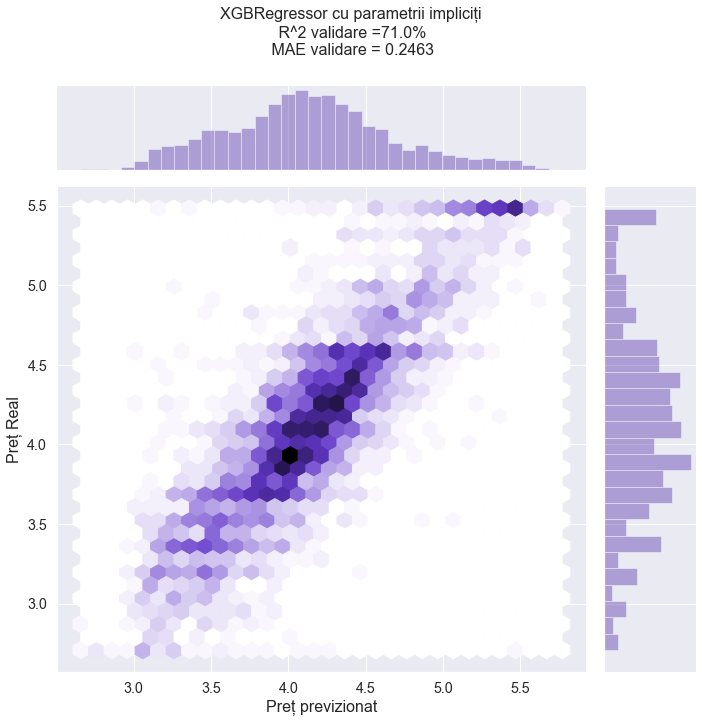

In [73]:

ax = sns.jointplot(x = val_preds_xgb, y = y_test, height = 10, color = '#512da8', kind = 'hex').set_axis_labels('Preț previzionat','Preț Real',fontsize = 16)

ax.fig.suptitle(f'XGBRegressor cu parametrii impliciți \n R^2 validare ={100*(round(r2_score(y_test, val_preds_xgb),2))}% \n MAE validare = {round( mean_absolute_error(y_test, val_preds_xgb),4)} ', fontsize = 16)
plt.subplots_adjust(top=0.87)

plt.show()

### XGBRegressor with params

In [74]:
params

{'max_depth': 12,
 'min_child_weight': 9,
 'eta': 0.05,
 'subsample': 0.7,
 'colsample_bytree': 0.6,
 'objective': 'reg:squarederror',
 'eval_metric': 'mae',
 'validate_parameters': 1}

In [75]:
xgb_start = time.time()

#training
xgbRegrP = xgb.XGBRegressor(max_depth = params["max_depth"], 
                            min_child_weight = params["min_child_weight"],
                            learning_rate = params['eta'],
                            subsample = params["subsample"],
                            colsample_bytree = params["colsample_bytree"],
                            objective = 'reg:squarederror'
                           )

xgbRegrP.fit(X_train, y_train)

#predictions on test set
training_preds_xgbP = xgbRegrP.predict(X_train)
val_preds_xgbP = xgbRegrP.predict(X_test)

xgb_end = time.time()

print(f"Timp de rulare: {round((xgb_end - xgb_start),4)} secunde")
print("\nXGBRegressor cu parametrii imbunătățiți\n")
print("\nAntrenare MAE:", round(mean_absolute_error(y_train, training_preds_xgbP),4))
print("Validare MAE:", round(mean_absolute_error(y_test, val_preds_xgbP),4))
print("\nAntrenare MSE:", round(mean_squared_error(y_train, training_preds_xgbP),4))
print("Validare MSE:", round(mean_squared_error(y_test, val_preds_xgbP),4))
print("\nAntrenare r2:", round(r2_score(y_train, training_preds_xgbP),4))
print("Validare r2:", round(r2_score(y_test, val_preds_xgbP),4))

Timp de rulare: 2.6294 secunde

XGBRegressor cu parametrii imbunătățiți


Antrenare MAE: 0.168
Validare MAE: 0.2468

Antrenare MSE: 0.0511
Validare MSE: 0.11

Antrenare r2: 0.8657
Validare r2: 0.7158


It can be seen that a slight decrese in overfitting has occured.

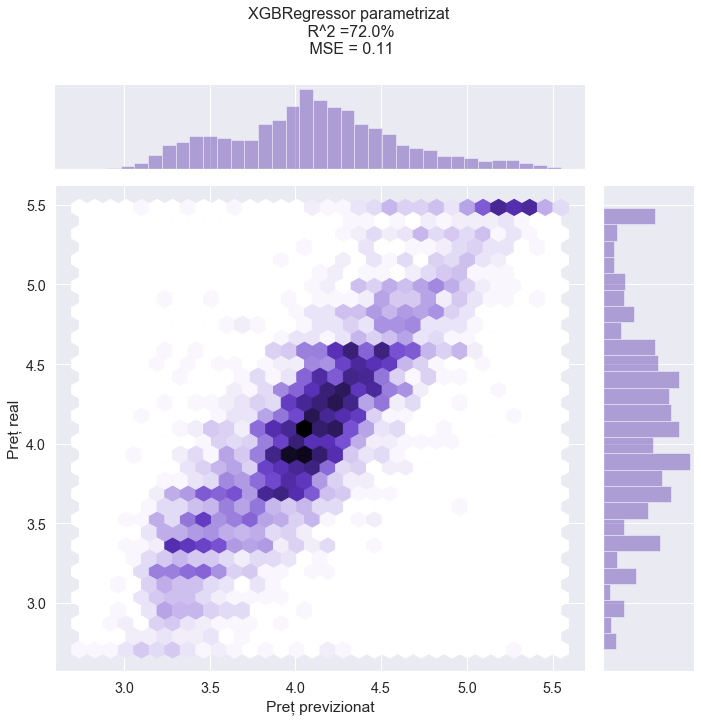

In [76]:
ax = sns.jointplot(x = val_preds_xgbP, y = y_test, height = 10, color = '#512da8', kind = 'hex').set_axis_labels('Preț previzionat','Preț real')

ax.fig.suptitle(f'XGBRegressor parametrizat \n R^2 ={100*(round(r2_score(y_test, val_preds_xgbP),2))}% \n MSE = {round( mean_squared_error(y_test, val_preds_xgbP),4)} ', fontsize = 16)
plt.subplots_adjust(top=0.87)

plt.show()

### Plots comparison HPM vs XGB

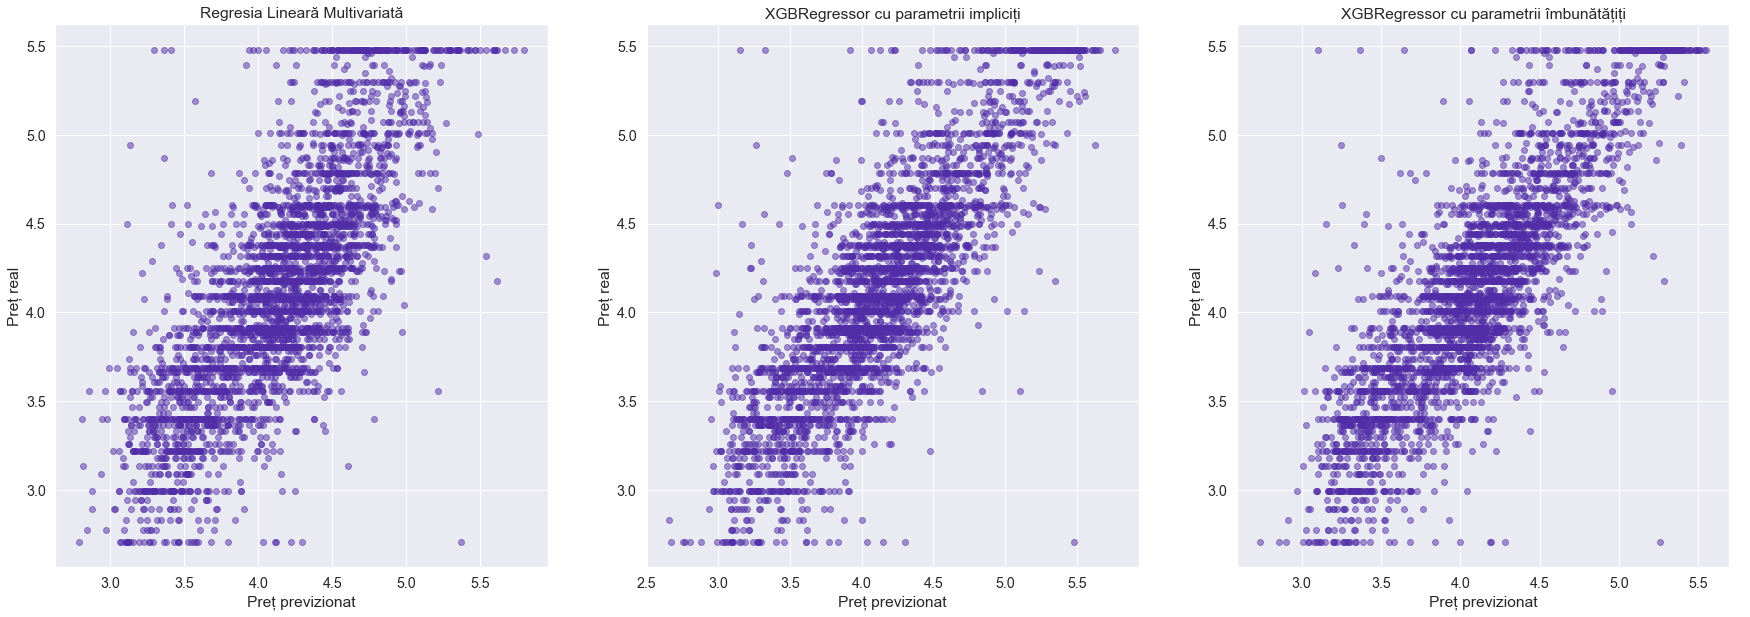

In [77]:
plt.figure(figsize = [30, 10])

plt.subplot(1, 3, 1)
plt.scatter(x = val_preds_hpm, y = y_test, alpha=.5, color='#512da8') 

overlay = f'R^2 ={100*(round(r2_score(y_test, val_preds_hpm),4))}% \n MAE = {round( mean_absolute_error(y_test, val_preds_hpm),4)} '
plt.annotate( s=overlay,xy=(5.1,2.5))
plt.xlabel('Preț previzionat')
plt.ylabel('Preț real')
plt.title('Regresia Lineară Multivariată')


plt.subplot(1,3,2)

plt.scatter(x = val_preds_xgb, y = y_test, alpha=.5, color='#512da8') 

overlay = f'R^2 ={100*(round(r2_score(y_test, val_preds_xgb),2))}% \n MAE = {round( mean_absolute_error(y_test, val_preds_xgb),4)} '
plt.annotate( s=overlay,xy=(5.1,2.5))
plt.xlabel('Preț previzionat')
plt.ylabel('Preț real')
plt.title('XGBRegressor cu parametrii impliciți')

plt.subplot(1,3,3)

plt.scatter(x = val_preds_xgbP, y = y_test, alpha=.5, color='#512da8') 

overlay = f'R^2 ={100*(round(r2_score(y_test, val_preds_xgbP),2))}% \n MAE = {round( mean_absolute_error(y_test, val_preds_xgbP),4)} '
plt.annotate( s=overlay,xy=(5.1,2.5))
plt.xlabel('Preț previzionat')
plt.ylabel('Preț real')
plt.title('XGBRegressor cu parametrii îmbunătățiți')



plt.show()

## Feature gain in XGB models

In [78]:
feature_gain_xgb = pd.DataFrame(xgbRegr.feature_importances_, columns=['gain'], index=X_train.columns)
feature_gain_xgb.sort_values('gain', ascending=False, inplace=True)

feature_gain_xgbP = pd.DataFrame(xgbRegrP.feature_importances_, columns=['gain'], index=X_train.columns)
feature_gain_xgbP.sort_values('gain', ascending=False, inplace=True)


In [79]:
print('Importanța Variabilelor XGBRegressor \ncu parametrii impliciți: \n',feature_gain_xgb.head(15), '\n')
print('Importanța Variabilelor XGBRegressor \ncu parametrii îmbunătățiți: \n',feature_gain_xgbP.head(15))

Importanța Variabilelor XGBRegressor 
cu parametrii impliciți: 
                                   gain
room_type_Entire home/apt      0.42715
room_type_Hotel room           0.14749
property_type_Other            0.04725
district_Innere Stadt          0.04072
accommodates                   0.02693
tv                             0.02186
air_conditioning               0.01603
review_scores_location_9/10    0.01025
cleaning_fee                   0.00719
bathrooms                      0.00700
district_Ottakring             0.00640
extra_people                   0.00576
review_scores_rating_80-94/100 0.00562
district_Neubau                0.00529
district_Simmering             0.00517 

Importanța Variabilelor XGBRegressor 
cu parametrii îmbunătățiți: 
                                 gain
room_type_Entire home/apt    0.30053
room_type_Hotel room         0.10955
accommodates                 0.07751
property_type_Other          0.06737
district_Innere Stadt        0.05144
tv                 

### plotting feature gain

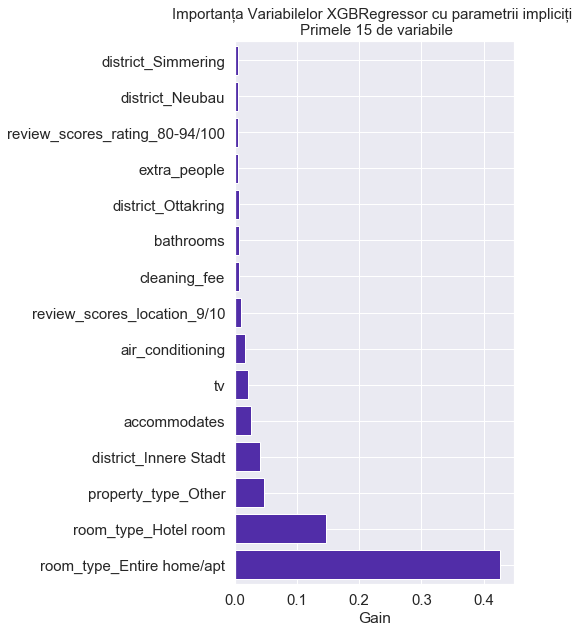

In [80]:
# Plotting feature gain
fig = plt.figure(figsize=(5,10))

plt.barh(feature_gain_xgb.index[0:15], feature_gain_xgb.gain[0:15], align='center',color='#512da8') 
plt.title("Importanța Variabilelor XGBRegressor cu parametrii impliciți \n Primele 15 de variabile", fontsize=15)
plt.xlabel("Gain")
plt.margins(y=0.01)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
fig.patch.set_facecolor('xkcd:white')
plt.show()

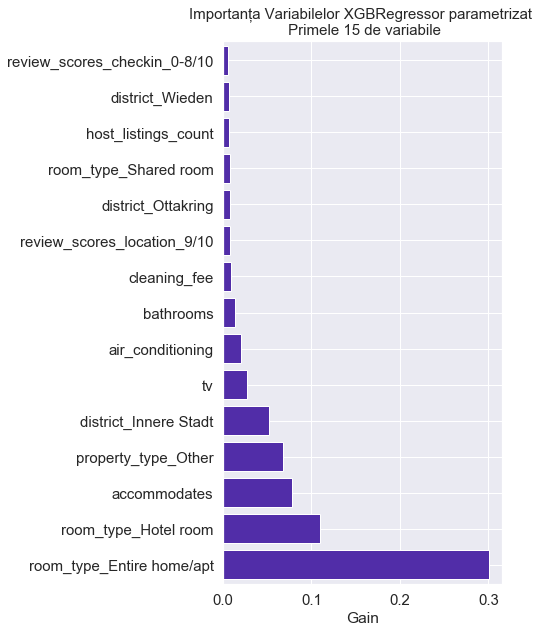

In [81]:
# Plotting feature gain
fig = plt.figure(figsize=(5,10))

plt.barh(feature_gain_xgbP.index[0:15], feature_gain_xgbP.gain[0:15], align='center',color='#512da8') 
plt.title("Importanța Variabilelor XGBRegressor parametrizat \n Primele 15 de variabile", fontsize=15)
plt.xlabel("Gain")
plt.margins(y=0.01)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
fig.patch.set_facecolor('xkcd:white')
plt.show()

## Models without reviews columns

It was noted that a lot of the review columns are reasonably highly correlated with each other. They were left in to see whether they would be useful after all. However, the feature importances graph produced by the XGBoost model suggest that they were of relatively low importance - excepting the review for location.

This model will drop review columns other than the overall review rating, and use the same Hedonic regression and XGBoost structure, in order to see whether this produces a better models.

Columns will be dropped from the existing X_train and X_test split, for consistency.



In [82]:
all_review = list(X_train.columns[X_train.columns.str.startswith("review_scores")])
review_to_keep = list(X_train.columns[X_train.columns.str.startswith("review_scores_rating")])
review_to_drop = [x for x in all_review if x not in review_to_keep]

X_train_short = X_train.drop(review_to_drop, axis=1)
X_test_short = X_test.drop(review_to_drop, axis=1)

In [83]:
len(review_to_drop)

18

In [84]:
review_to_drop

['review_scores_accuracy_0-8/10',
 'review_scores_accuracy_10/10',
 'review_scores_accuracy_9/10',
 'review_scores_cleanliness_0-8/10',
 'review_scores_cleanliness_10/10',
 'review_scores_cleanliness_9/10',
 'review_scores_checkin_0-8/10',
 'review_scores_checkin_10/10',
 'review_scores_checkin_9/10',
 'review_scores_communication_0-8/10',
 'review_scores_communication_10/10',
 'review_scores_communication_9/10',
 'review_scores_location_0-8/10',
 'review_scores_location_10/10',
 'review_scores_location_9/10',
 'review_scores_value_0-8/10',
 'review_scores_value_10/10',
 'review_scores_value_9/10']

### HPM without ratings

In [85]:
hpm_start = time.time()

# Create instance of `LinearRegression` and fit the model on the training data:
hpm1 = LinearRegression()
hpm1.fit(X_train_short, y_train) #training the algorithm

# Make predictions by calling the predict command on the test set
training_preds_hpm1 = hpm1.predict(X_train_short)
val_preds_hpm1 = hpm1.predict(X_test_short)

hpm_end = time.time()

print(f"Time taken to run: {round((hpm_end - hpm_start),4)} seconds")

# Check the predictions against the actual values by using the metrics:

print("HPM with dropped columns: \n")
print("\nTraining MAE:", round(mean_absolute_error(y_train, training_preds_hpm1),4))
print("Validation MAE:", round(mean_absolute_error(y_test, val_preds_hpm1),4))

print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_hpm1),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_hpm1),4))

print("\nTraining R2:", round(r2_score(y_train, training_preds_hpm1),4))
print("Validation R2:", round(r2_score(y_test, val_preds_hpm1),4))

print("\nHPM with all columns: \n")
print("\nTraining MAE:", round(mean_absolute_error(y_train, training_preds_hpm),4))
print("Validation MAE:", round(mean_absolute_error(y_test, val_preds_hpm),4))

print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_hpm),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_hpm),4))

print("\nTraining R2:", round(r2_score(y_train, training_preds_hpm),4))
print("Validation R2:", round(r2_score(y_test, val_preds_hpm),4))

Time taken to run: 0.0249 seconds
HPM with dropped columns: 


Training MAE: 0.2969
Validation MAE: 0.3029

Training MSE: 0.1492
Validation MSE: 0.1567

Training R2: 0.608
Validation R2: 0.5954

HPM with all columns: 


Training MAE: 0.2948
Validation MAE: 0.3009

Training MSE: 0.1475
Validation MSE: 0.1548

Training R2: 0.6125
Validation R2: 0.6003


No better results

### XGB default without ratings

In [86]:
xgb_start = time.time()

#training
xgbRegr1 = xgb.XGBRegressor()
xgbRegr1.fit(X_train_short, y_train)

#predictions on test set
training_preds_xgb1 = xgbRegr1.predict(X_train_short)
val_preds_xgb1 = xgbRegr1.predict(X_test_short)

xgb_end = time.time()

print("XGBRegressor cu parametrii impliciți, \nfără coloanele cu ratinguri:\n")
print(f"Timp de rulare: {round((xgb_end - xgb_start),4)} secunde")
print("\nAntrenare MAE:", round(mean_absolute_error(y_train, training_preds_xgb1),4))
print("Validare MAE:", round(mean_absolute_error(y_test, val_preds_xgb1),4))
print("\nAntrenare MSE:", round(mean_squared_error(y_train, training_preds_xgb1),4))
print("Validare MSE:", round(mean_squared_error(y_test, val_preds_xgb1),4))
print("\nAntrenare r2:", round(r2_score(y_train, training_preds_xgb1),4))
print("Validare r2:", round(r2_score(y_test, val_preds_xgb1),4))

print("\nXGBRegressor cu parametrii impliciți, \ntoate coloanele:\n")

print("\nAntrenare MAE:", round(mean_absolute_error(y_train, training_preds_xgb),4))
print("Validare MAE:", round(mean_absolute_error(y_test, val_preds_xgb),4))
print("\nAntrenare MSE:", round(mean_squared_error(y_train, training_preds_xgb),4))
print("Validare MSE:", round(mean_squared_error(y_test, val_preds_xgb),4))
print("\nAntrenare r2:", round(r2_score(y_train, training_preds_xgb),4))
print("Validare r2:", round(r2_score(y_test, val_preds_xgb),4))

XGBRegressor cu parametrii impliciți, 
fără coloanele cu ratinguri:

Timp de rulare: 1.5957 secunde

Antrenare MAE: 0.1374
Validare MAE: 0.2512

Antrenare MSE: 0.0345
Validare MSE: 0.1153

Antrenare r2: 0.9093
Validare r2: 0.7023

XGBRegressor cu parametrii impliciți, 
toate coloanele:


Antrenare MAE: 0.1357
Validare MAE: 0.2463

Antrenare MSE: 0.0342
Validare MSE: 0.1122

Antrenare r2: 0.9101
Validare r2: 0.7103


### XGB params without ratings

In [87]:
params

{'max_depth': 12,
 'min_child_weight': 9,
 'eta': 0.05,
 'subsample': 0.7,
 'colsample_bytree': 0.6,
 'objective': 'reg:squarederror',
 'eval_metric': 'mae',
 'validate_parameters': 1}

In [88]:
xgb_start = time.time()

#training
xgbRegrP1 = xgb.XGBRegressor(max_depth = params["max_depth"], 
                            min_child_weight = params["min_child_weight"],
                            learning_rate = 0.05,
                            subsample = params["subsample"],
                            colsample_bytree = params["colsample_bytree"],
                            objective = 'reg:squarederror'
                           )

xgbRegrP1.fit(X_train_short, y_train)

#predictions on test set
training_preds_xgbP1 = xgbRegrP1.predict(X_train_short)
val_preds_xgbP1 = xgbRegrP1.predict(X_test_short)

xgb_end = time.time()

print("XGBRegressor parametrizat, \nfără coloanele cu ratinguri:\n")
print(f"Timp de rulare: {round((xgb_end - xgb_start),4)} secunde")
print("\nAntrenare MAE:", round(mean_absolute_error(y_train, training_preds_xgbP1),4))
print("Validare MAE:", round(mean_absolute_error(y_test, val_preds_xgbP1),4))
print("\nAntrenare MSE:", round(mean_squared_error(y_train, training_preds_xgbP1),4))
print("Validare MSE:", round(mean_squared_error(y_test, val_preds_xgbP1),4))
print("\nAntrenare r2:", round(r2_score(y_train, training_preds_xgbP1),4))
print("Validare r2:", round(r2_score(y_test, val_preds_xgbP1),4))

print("\nXGBRegressor parametrizat, \ntoate coloanele:\n")
print("\nAntrenare MAE:", round(mean_absolute_error(y_train, training_preds_xgbP),4))
print("Validare MAE:", round(mean_absolute_error(y_test, val_preds_xgbP),4))
print("\nAntrenare MSE:", round(mean_squared_error(y_train, training_preds_xgbP),4))
print("Validare MSE:", round(mean_squared_error(y_test, val_preds_xgbP),4))
print("\nAntrenare r2:", round(r2_score(y_train, training_preds_xgbP),4))
print("Validare r2:", round(r2_score(y_test, val_preds_xgbP),4))


XGBRegressor parametrizat, 
fără coloanele cu ratinguri:

Timp de rulare: 2.0216 secunde

Antrenare MAE: 0.172
Validare MAE: 0.247

Antrenare MSE: 0.0533
Validare MSE: 0.1099

Antrenare r2: 0.8599
Validare r2: 0.7162

XGBRegressor parametrizat, 
toate coloanele:


Antrenare MAE: 0.168
Validare MAE: 0.2468

Antrenare MSE: 0.0511
Validare MSE: 0.11

Antrenare r2: 0.8657
Validare r2: 0.7158


A slight improvement can be seen.

**Both Spatial Hedonic Regression and XGBoost perform almost the same without the additional review columns**

***Hence, because they are able to achieve the same performance with 18 fewer columns, the second models are the preferred models as they require less data and are less computationally expensive.***

A slight improvement of the XGBRegressor params will be sought by dropping columns based on xgb gain

## feature importances for best model - xgb params without reviews

In [93]:
feature_gain_xgbP1 = pd.DataFrame(xgbRegrP1.feature_importances_, columns=['gain'], index=X_train_short.columns)
feature_gain_xgbP1.sort_values('gain', ascending=False, inplace=True)

In [94]:
print('Importanța Variabilelor XGBRegressor parametrizat, \nfără variabilele ratings: \n',feature_gain_xgbP1.head(15), '\n')

Importanța Variabilelor XGBRegressor parametrizat, 
fără variabilele ratings: 
                              gain
room_type_Entire home/apt 0.32207
room_type_Hotel room      0.14343
property_type_Other       0.08579
accommodates              0.05999
district_Innere Stadt     0.05228
air_conditioning          0.02557
tv                        0.02251
bathrooms                 0.01580
district_Neubau           0.00797
room_type_Shared room     0.00790
cleaning_fee              0.00750
district_Ottakring        0.00697
host_listings_count       0.00694
district_Wieden           0.00644
district_Floridsdorf      0.00627 



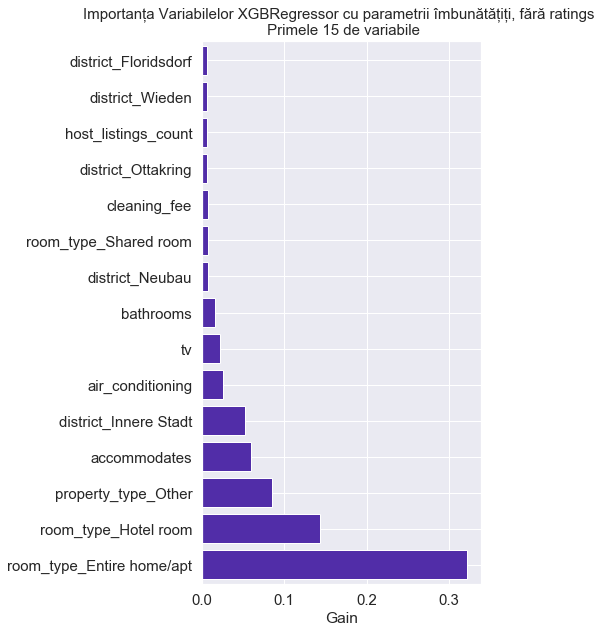

In [95]:
# Plotting feature gain
fig = plt.figure(figsize=(5,10))

plt.barh(feature_gain_xgbP1.index[0:15], feature_gain_xgbP1.gain[0:15], align='center',color='#512da8') 
plt.title("Importanța Variabilelor XGBRegressor cu parametrii îmbunătățiți, fără ratings \n Primele 15 de variabile", fontsize=15)
plt.xlabel("Gain")
plt.margins(y=0.01)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
fig.patch.set_facecolor('xkcd:white')
plt.show()

## Dropping columns by feature gain
A further improvement will be sought by dropping all of the features that are not in the top 15 by XGB gain metric.


Apart from its superior performance, a benefit of using ensembles of decision tree methods like gradient boosting is that they can automatically provide estimates of feature importance from a trained predictive model.

Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.

Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. The performance measure may be the purity (Gini index) used to select the split points or another more specific error function.

The feature importances are then averaged across all of the the decision trees within the model.

For more detailed information on how feature importance is calculated in boosted decision trees, see this answer in [StackOverflow](https://stats.stackexchange.com/questions/162162/relative-variable-importance-for-boosting)

The Gain implies the relative contribution of the corresponding feature to the model calculated by taking each feature’s contribution for each tree in the model. A higher value of this metric when compared to another feature implies it is more important for generating a prediction.

In [96]:
feature_gain_xgb1 = pd.DataFrame(xgbRegr1.feature_importances_, columns=['gain'], index=X_train_short.columns)
feature_gain_xgb1.sort_values('gain', ascending=False, inplace=True)

feature_gain_xgbP1 = pd.DataFrame(xgbRegrP1.feature_importances_, columns=['gain'], index=X_train_short.columns)
feature_gain_xgbP1.sort_values('gain', ascending=False, inplace=True)


In [97]:
print('Primele 15 variabile în ordinea importanței\nXGBRegressor cu parametrii impliciți: \n',feature_gain_xgb1.head(15), '\n')
print('Primele 15 variabile în ordinea importanței\nXGBRegressor parametrizat: \n',feature_gain_xgbP1.head(15), '\n')

Primele 15 variabile în ordinea importanței
XGBRegressor cu parametrii impliciți: 
                                   gain
room_type_Entire home/apt      0.33664
room_type_Hotel room           0.26475
property_type_Other            0.06453
district_Innere Stadt          0.04357
accommodates                   0.02405
tv                             0.01851
air_conditioning               0.01526
district_Simmering             0.00740
district_Ottakring             0.00735
district_Neubau                0.00636
district_Floridsdorf           0.00632
review_scores_rating_80-94/100 0.00628
bathrooms                      0.00615
district_Hernals               0.00563
cleaning_fee                   0.00542 

Primele 15 variabile în ordinea importanței
XGBRegressor parametrizat: 
                              gain
room_type_Entire home/apt 0.32207
room_type_Hotel room      0.14343
property_type_Other       0.08579
accommodates              0.05999
district_Innere Stadt     0.05228
air_condition

## 15 feature 

In [98]:
print('X_test and train for XGB default: \n')
all_columns = list(X_train_short.columns)
to_keep = list(feature_gain_xgb1.index[0:15])
to_drop = [x for x in all_columns if x not in to_keep]

X_15trainXgb1 = X_train_short.drop(to_drop, axis = 1)
X_15testXgb1 = X_test_short.drop(to_drop,axis = 1)
X_15trainXgb1.info()

X_test and train for XGB default: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8397 entries, 8221 to 3582
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   accommodates                    8397 non-null   float64
 1   bathrooms                       8397 non-null   float64
 2   cleaning_fee                    8397 non-null   float64
 3   air_conditioning                8397 non-null   float64
 4   tv                              8397 non-null   float64
 5   district_Floridsdorf            8397 non-null   float64
 6   district_Hernals                8397 non-null   float64
 7   district_Innere Stadt           8397 non-null   float64
 8   district_Neubau                 8397 non-null   float64
 9   district_Ottakring              8397 non-null   float64
 10  district_Simmering              8397 non-null   float64
 11  property_type_Other             8397 non-null   float64


In [99]:
print('X_test and train for XGB params: \n')
all_columns = list(X_train_short.columns)
to_keep = list(feature_gain_xgbP1.index[0:15])
to_drop = [x for x in all_columns if x not in to_keep]

X_15trainXgbP1 = X_train_short.drop(to_drop, axis = 1)
X_15testXgbP1 = X_test_short.drop(to_drop,axis = 1)
X_15trainXgbP1.info()

X_test and train for XGB params: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8397 entries, 8221 to 3582
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   host_listings_count        8397 non-null   float64
 1   accommodates               8397 non-null   float64
 2   bathrooms                  8397 non-null   float64
 3   cleaning_fee               8397 non-null   float64
 4   air_conditioning           8397 non-null   float64
 5   tv                         8397 non-null   float64
 6   district_Floridsdorf       8397 non-null   float64
 7   district_Innere Stadt      8397 non-null   float64
 8   district_Neubau            8397 non-null   float64
 9   district_Ottakring         8397 non-null   float64
 10  district_Wieden            8397 non-null   float64
 11  property_type_Other        8397 non-null   float64
 12  room_type_Entire home/apt  8397 non-null   float64
 13  room_type_

## XGBRegressor default  15 features

In [100]:
xgb_start = time.time()

#training
xgbRegr15 = xgb.XGBRegressor()
xgbRegr15.fit(X_15trainXgb1, y_train)

#predictions on test set
training_preds_xgb15 = xgbRegr15.predict(X_15trainXgb1)
val_preds_xgb15 = xgbRegr15.predict(X_15testXgb1)

xgb_end = time.time()

print("XGBRegressor cu parametrii impliciți, \ncele mai importante 15 variabile:\n")
print(f"Timp de rulare: {round((xgb_end - xgb_start),4)} secunde")
print("\nAntrenare MAE:", round(mean_absolute_error(y_train, training_preds_xgb15),4))
print("Validare MAE:", round(mean_absolute_error(y_test, val_preds_xgb15),4))
print("\nAntrenare MSE:", round(mean_squared_error(y_train, training_preds_xgb15),4))
print("Validare MSE:", round(mean_squared_error(y_test, val_preds_xgb15),4))
print("\nAntrenare r2:", round(r2_score(y_train, training_preds_xgb15),4))
print("Validare r2:", round(r2_score(y_test, val_preds_xgb15),4))

print("\nXGBRegressor cu parametrii impliciți, \nfără coloanele cu ratinguri:\n")
print("Antrenare MAE:", round(mean_absolute_error(y_train, training_preds_xgb1),4))
print("Validare MAE:", round(mean_absolute_error(y_test, val_preds_xgb1),4))
print("\nAntrenare MSE:", round(mean_squared_error(y_train, training_preds_xgb1),4))
print("Validare MSE:", round(mean_squared_error(y_test, val_preds_xgb1),4))
print("\nAntrenare r2:", round(r2_score(y_train, training_preds_xgb1),4))
print("Validare r2:", round(r2_score(y_test, val_preds_xgb1),4))

print("\nXGBRegressor cu parametrii impliciți, \ntoate coloanele:\n")

print("Antrenare MAE:", round(mean_absolute_error(y_train, training_preds_xgb),4))
print("Validare MAE:", round(mean_absolute_error(y_test, val_preds_xgb),4))
print("\nAntrenare MSE:", round(mean_squared_error(y_train, training_preds_xgb),4))
print("Validare MSE:", round(mean_squared_error(y_test, val_preds_xgb),4))
print("\nAntrenare r2:", round(r2_score(y_train, training_preds_xgb),4))
print("Validare r2:", round(r2_score(y_test, val_preds_xgb),4))

XGBRegressor cu parametrii impliciți, 
cele mai importante 15 variabile:

Timp de rulare: 0.356 secunde

Antrenare MAE: 0.2479
Validare MAE: 0.2949

Antrenare MSE: 0.1118
Validare MSE: 0.1552

Antrenare r2: 0.7063
Validare r2: 0.5992

XGBRegressor cu parametrii impliciți, 
fără coloanele cu ratinguri:

Antrenare MAE: 0.1374
Validare MAE: 0.2512

Antrenare MSE: 0.0345
Validare MSE: 0.1153

Antrenare r2: 0.9093
Validare r2: 0.7023

XGBRegressor cu parametrii impliciți, 
toate coloanele:

Antrenare MAE: 0.1357
Validare MAE: 0.2463

Antrenare MSE: 0.0342
Validare MSE: 0.1122

Antrenare r2: 0.9101
Validare r2: 0.7103


## XGBRegressor  params 15 features

In [101]:
xgb_start = time.time()

#training
xgbRegr15P = xgb.XGBRegressor()
xgbRegr15P.fit(X_15trainXgbP1, y_train)

#predictions on test set
training_preds_xgb15P = xgbRegr15P.predict(X_15trainXgbP1)
val_preds_xgb15P = xgbRegr15P.predict(X_15testXgbP1)

xgb_end = time.time()



print("\nXGBRegressor parametrizat, \ncele mai importante 15 variabile:\n")
print(f"Timp de rulare: {round((xgb_end - xgb_start),4)} secunde")
print("\nTraining MAE:", round(mean_absolute_error(y_train, training_preds_xgb15P),4))
print("Validation MAE:", round(mean_absolute_error(y_test, val_preds_xgb15P),4))
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb15P),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb15P),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb15P),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb15P),4))

print("XGBRegressor parametrizat, \nfără coloanele cu ratinguri:\n")
print("Antrenare MAE:", round(mean_absolute_error(y_train, training_preds_xgbP1),4))
print("Validare MAE:", round(mean_absolute_error(y_test, val_preds_xgbP1),4))
print("\nAntrenare MSE:", round(mean_squared_error(y_train, training_preds_xgbP1),4))
print("Validare MSE:", round(mean_squared_error(y_test, val_preds_xgbP1),4))
print("\nAntrenare r2:", round(r2_score(y_train, training_preds_xgbP1),4))
print("Validare r2:", round(r2_score(y_test, val_preds_xgbP1),4))

print("\nXGBRegressor parametrizat, \ntoate coloanele:\n")
print("Antrenare MAE:", round(mean_absolute_error(y_train, training_preds_xgbP),4))
print("Validare MAE:", round(mean_absolute_error(y_test, val_preds_xgbP),4))
print("\nAntrenare MSE:", round(mean_squared_error(y_train, training_preds_xgbP),4))
print("Validare MSE:", round(mean_squared_error(y_test, val_preds_xgbP),4))
print("\nAntrenare r2:", round(r2_score(y_train, training_preds_xgbP),4))
print("Validare r2:", round(r2_score(y_test, val_preds_xgbP),4))


XGBRegressor parametrizat, 
cele mai importante 15 variabile:

Timp de rulare: 0.3072 secunde

Training MAE: 0.2236
Validation MAE: 0.2717

Training MSE: 0.0929
Validation MSE: 0.1365

Training r2: 0.7558
Validation r2: 0.6474
XGBRegressor parametrizat, 
fără coloanele cu ratinguri:

Antrenare MAE: 0.172
Validare MAE: 0.247

Antrenare MSE: 0.0533
Validare MSE: 0.1099

Antrenare r2: 0.8599
Validare r2: 0.7162

XGBRegressor parametrizat, 
toate coloanele:

Antrenare MAE: 0.168
Validare MAE: 0.2468

Antrenare MSE: 0.0511
Validare MSE: 0.11

Antrenare r2: 0.8657
Validare r2: 0.7158


As it can be seen, dropping features isn't helping at all; both models perform way worse

## Final model selection

Overall, the XGBRegressor model with hyperparameters and without all of the reviews columns is the preferred model, which performs better than both Hedonic Regression Models and seems not to overfit as much as the default XGBRegressor model. It's also less computationally expensive. 

# Conclusions and Recommendations

The best performing model was able to predict 71% of the variation in price with an MSE of 0.13 on the validation set. Which means we still have a remaining 29% unexplained. This could be due to several other features that are not part of our dataset or the need to analyse our features more closely.It is likely that a significant proportion of this unexplained variance is due to variations in the listing photos. The photos of properties on Airbnb are very important in encouraging guests to book, and so can also be expected to have a significant impact on price - better photos (primarily better quality properties and furnishings, but also better quality photography) equal higher prices.

For example, given the importance of customer reviews of the listing in determining price, perhaps a better understanding of the reviews could improve the prediction. Using Sentiment Analysis, a score between -1 (very negative sentiment) and 1 (very positive sentiment) can be assigned to each review per listing property. The scores are then averaged across all the reviews associated with that listing and the final scores can be included as a new feature in the model (see [here](https://arxiv.org/pdf/1907.12665.pdf) for an example).

Another suggestion is the inclusion of image quality as a feature. Using Difference-in-Difference deep learning and supervised learning analyses on a Airbnb panel dataset, researchers found that units with verified photos (taken by Airbnb’s photographers) generate additional revenue per year on average (see [here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2976021)).

It was noticeable that reviews about listing location, rather than the location features themselves, were higher in the feature importance list. Thus, this finding could perhaps be used by Airbnb hosts when writing their listing's description. Highlighting accessibility and location benefits of staying with them could perhaps benefit them and how much they can ask for their listing.

## Potential future developments

* Find a way to incorporate image quality into the model, e.g. by using the output of a convolutional neural network to assess image quality as an input into the pricing model
* Use better quality/more accurate data which includes the actual average prices paid per night
* Include a wider geographic area, e.g. the rest of Austria or other major cities around the world
* Augment the model with natural language processing (NLP) of listing descriptions and/or reviews, e.g. for sentiment analysis or looking for keywords
* In addition to predicting base prices, a sequence model could be created to calculate daily rates using data on seasonality and occupancy, which would allow the creation of actual pricing software
* Tailor the model more specifically to new listings in order to help hosts set prices for new properties, by removing features that would not be known at the time - e.g. other fees, availability and reviews